In [1]:
import pandas as pd
import numpy as np
from pycaret.clustering import *
import sweetviz as sw
from datetime import date
from scipy import stats
import matplotlib.pyplot as plt


def create_plot(df, feat_list, feat_groupby, title, sort=None, pct=False):
    if sort is None:
        sort = feat_list
    else:
        sort = sort

    if pct:
        (
            df
            .groupby(feat_groupby)
            .mean().mul(100).round(1)
            .reset_index()
            .sort_values(by=sort, ascending=False)
            .plot(x=feat_groupby, y=feat_list, kind="bar", figsize=(10,6), legend=True, grid=False, title=title)
        )
    else:
        (
            df
            .groupby(feat_groupby)
            .mean()
            .reset_index()
            .sort_values(by=sort, ascending=False)
            .plot(x=feat_groupby, y=feat_list, kind="bar", figsize=(10,6), legend=True, grid=False, title=title)
        )
        
    plt.show()

In [2]:
raw = pd.read_csv('data/Customer analysis - Customer analysis.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
raw[raw['Income'].isnull()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,15-11-2013,11,5,...,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,20-02-2013,19,5,...,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,05-11-2013,80,81,...,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,01-01-2014,96,48,...,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,17-06-2013,57,11,...,6,0,0,0,0,0,0,3,11,0
71,10629,1973,2n Cycle,Married,NaN,1,0,14-09-2012,25,25,...,8,0,0,0,0,0,0,3,11,0
90,8996,1957,PhD,Married,NaN,2,1,19-11-2012,4,230,...,9,0,0,0,0,0,0,3,11,0
91,9235,1957,Graduation,Single,NaN,1,1,27-05-2014,45,7,...,7,0,0,0,0,0,0,3,11,0
92,5798,1973,Master,Together,NaN,0,0,23-11-2013,87,445,...,1,0,0,0,0,0,0,3,11,0
128,8268,1961,PhD,Married,NaN,0,1,11-07-2013,23,352,...,6,0,0,0,0,0,0,3,11,0


In [4]:
df =\
    (
        raw
        .dropna(axis=0)
        .assign(
            # clean some features
            Marital_Status = lambda x: x.Marital_Status.replace(['Alone', 'Absurd', 'YOLO'], 'Other'),
            # get new features
            ID = lambda x: x.ID.astype(str),
            Age = lambda x: 2023 - x.Year_Birth,
            CustDays = lambda x: (pd.to_datetime(date.today()) - pd.to_datetime(x.Dt_Customer)).dt.days,
            Childhome = lambda x: x.Kidhome + x.Teenhome,
            MntAllProducts = lambda x: x.MntWines + x.MntFruits + x.MntMeatProducts + x.MntFishProducts + x.MntSweetProducts + x.MntGoldProds,
            NumAllPurchases = lambda x: x.NumWebPurchases + x.NumCatalogPurchases + x.NumStorePurchases,
            # normalization
            # Income = lambda x: x.Income.apply(np.log1p),
            # MntWines = lambda x: x.MntWines.apply(np.log1p),
            # MntFruits = lambda x: x.MntFruits.apply(np.log1p),
            # MntMeatProducts = lambda x: x.MntMeatProducts.apply(np.log1p),
            # MntFishProducts = lambda x: x.MntFishProducts.apply(np.log1p),
            # MntSweetProducts = lambda x: x.MntSweetProducts.apply(np.log1p),
            # MntGoldProds = lambda x: x.MntGoldProds.apply(np.log1p), # -- dont know why this is the odd one out,
        )
        .drop(columns=['Year_Birth', 'Dt_Customer'])
        .loc[lambda x: ((np.abs(stats.zscore(x.Income)) < 3)) & ((np.abs(stats.zscore(x.Age)) < 3)) & ((np.abs(stats.zscore(x.MntAllProducts)) < 3))] # remove outliers
        .assign(
            # create bin for numerical features
            IncomeGroup = lambda x: pd.cut(x.Income, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            AgeGroup = lambda x: pd.cut(x.Age, 3, labels = ['Young', 'Adult', 'Elder']),
            AgeInterval = lambda x: pd.cut(x.Age, 3),
            MntAllGroup = lambda x: pd.cut(x.MntAllProducts, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            MntWinesGroup = lambda x: pd.cut(x.MntWines, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            MntMeatGroup = lambda x: pd.cut(x.MntMeatProducts, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            MntFruitsGroup = lambda x: pd.cut(x.MntFruits, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            MntFishGroup = lambda x: pd.cut(x.MntFishProducts, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            MntSweetGroup = lambda x: pd.cut(x.MntSweetProducts, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            MntGoldGroup = lambda x: pd.cut(x.MntGoldProds, 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
        )
    )

                                             |          | [  0%]   00:00 -> (? left)


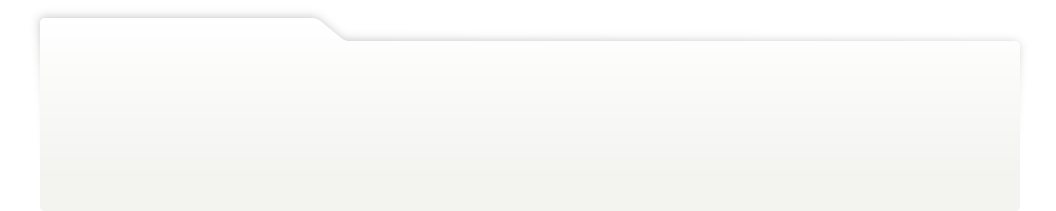
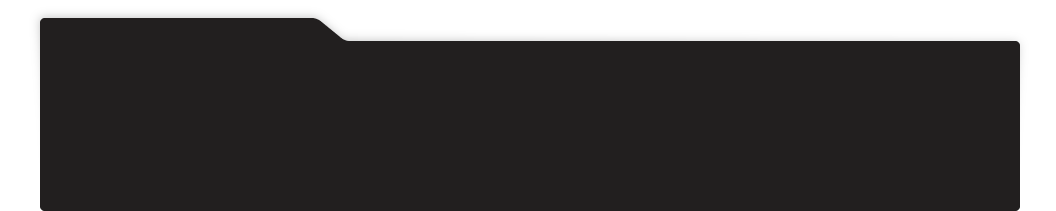
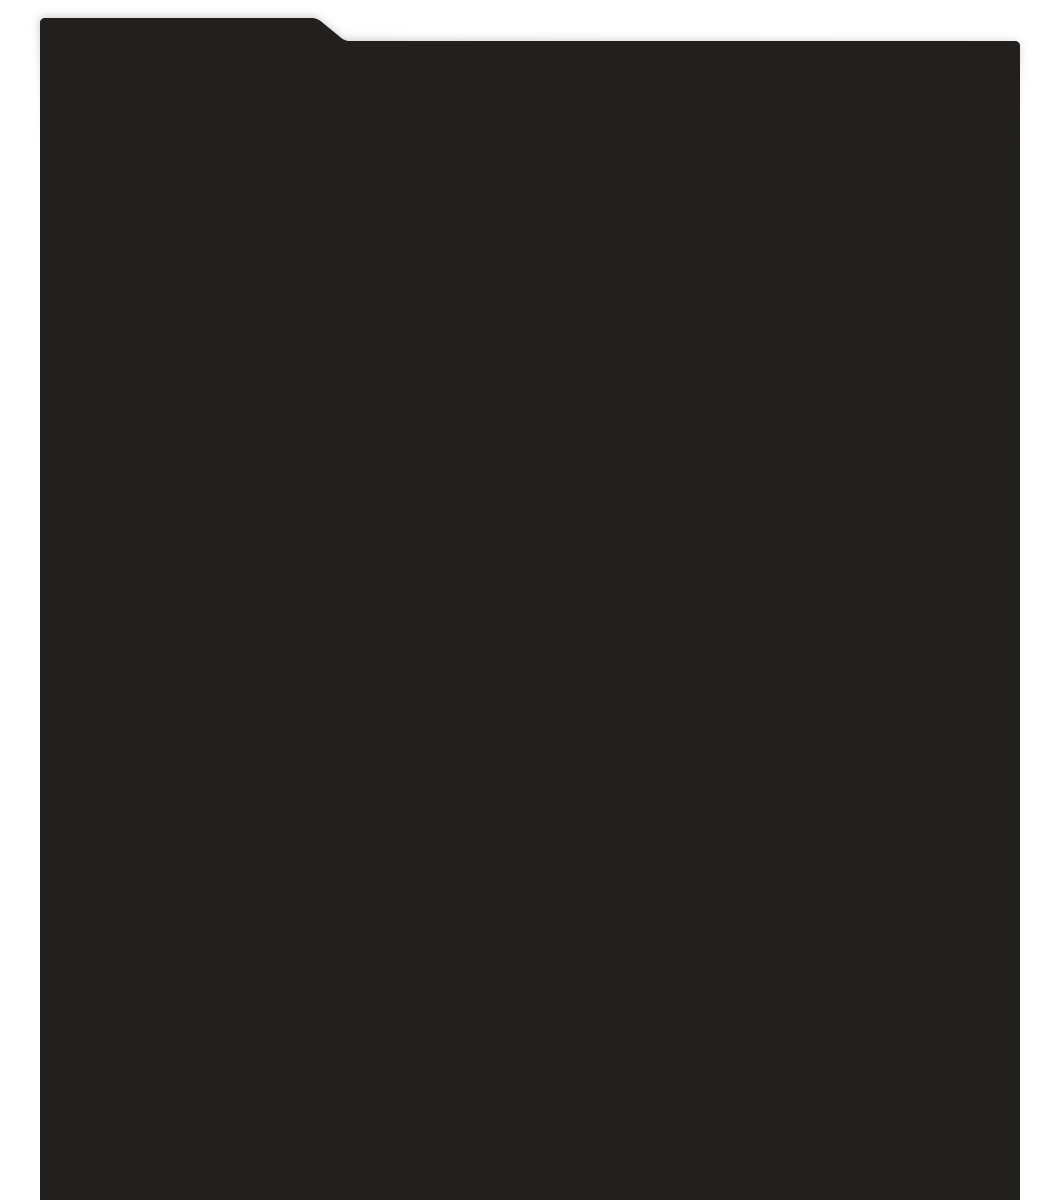
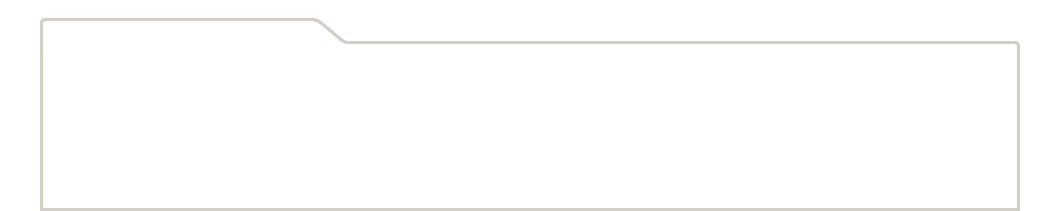
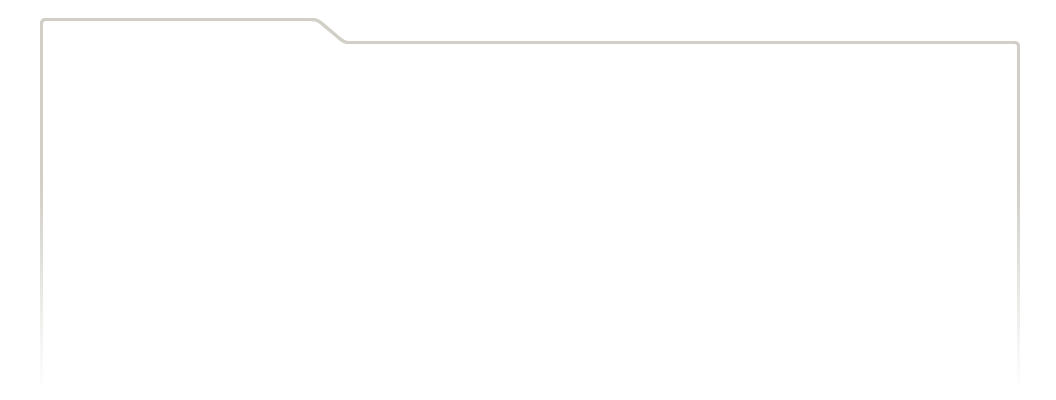
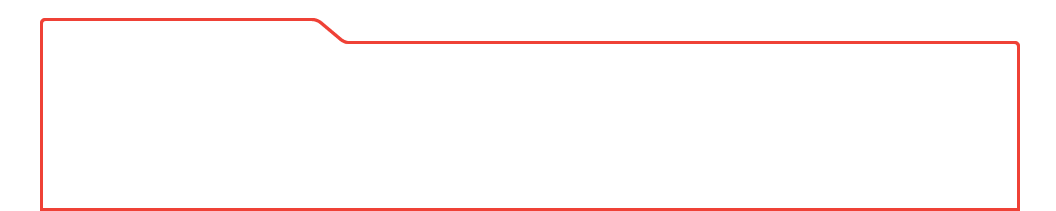
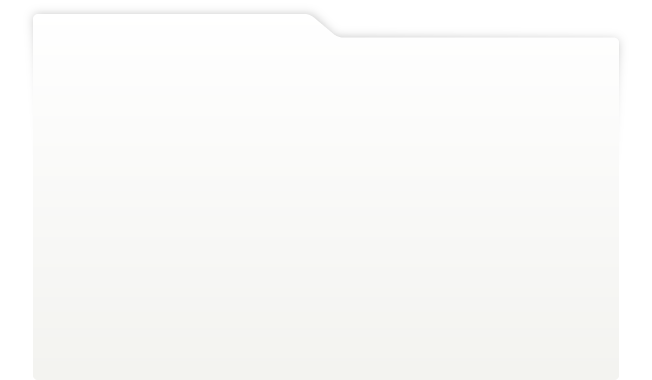
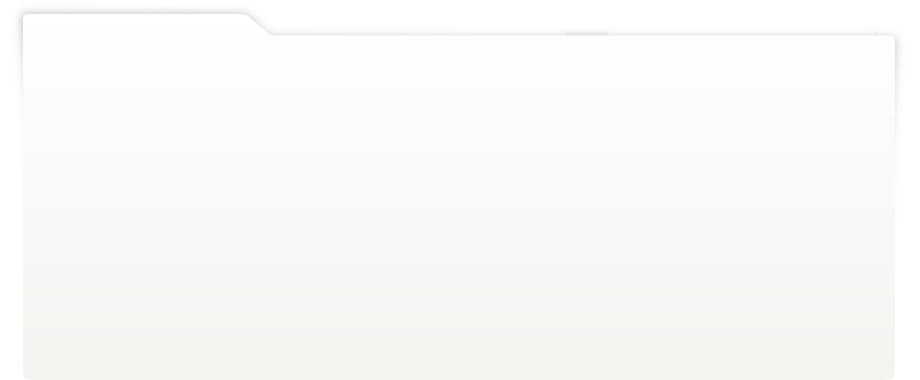
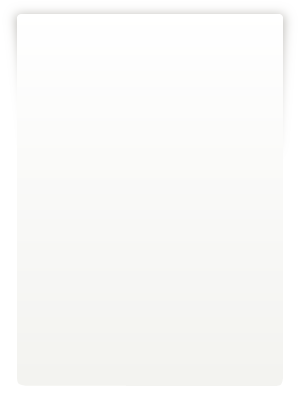
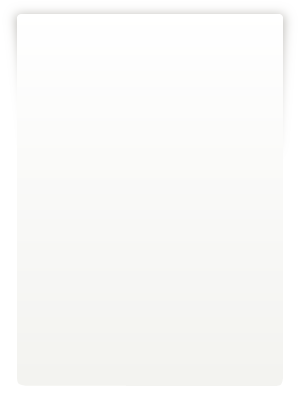
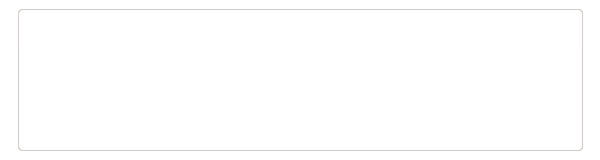
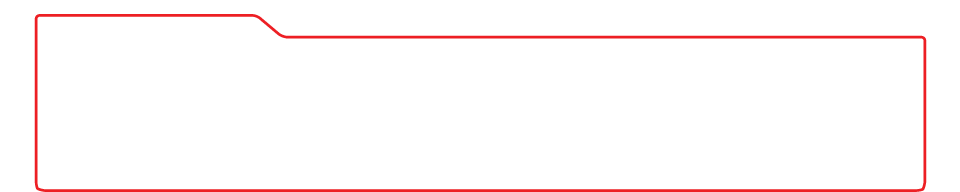
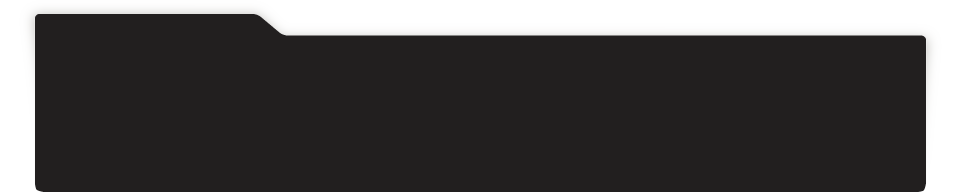
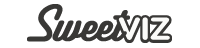
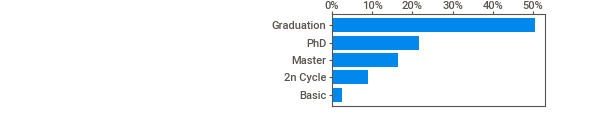
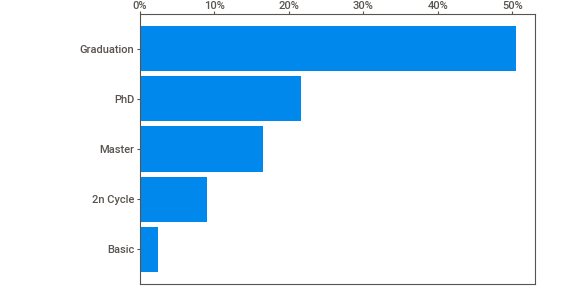
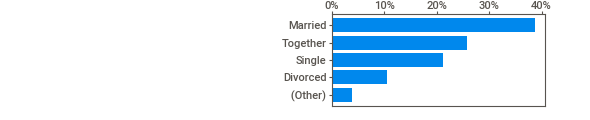
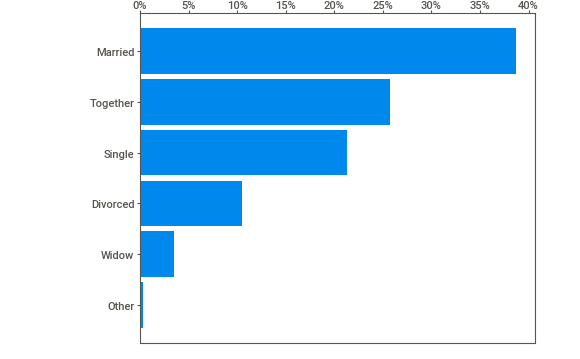
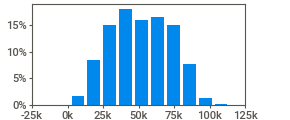
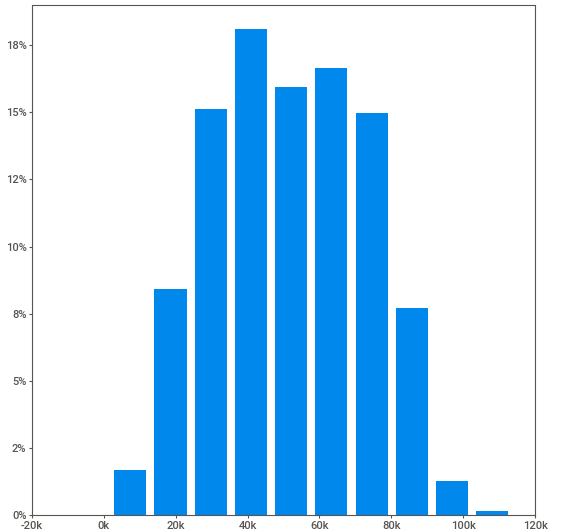
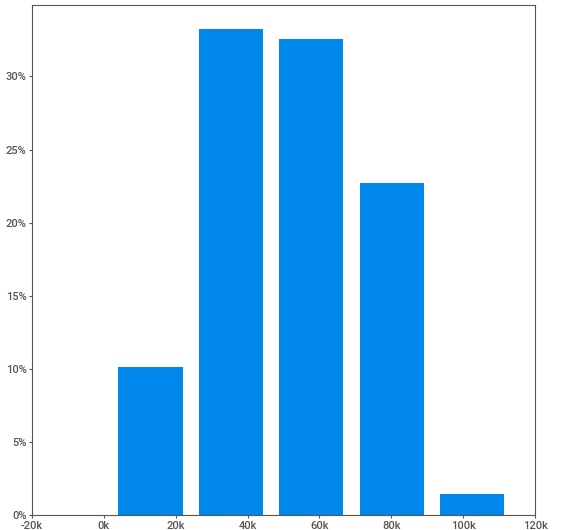
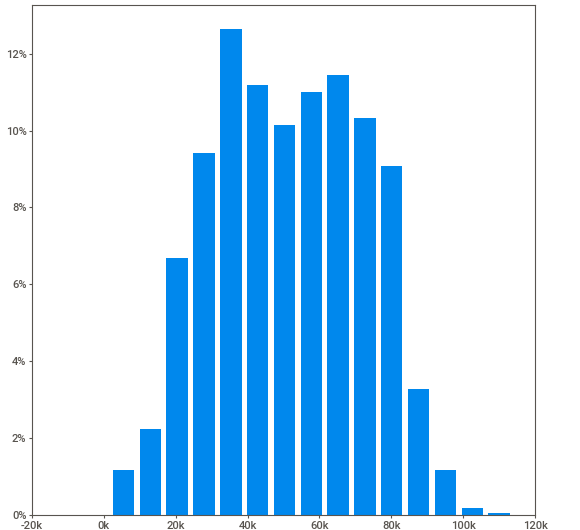
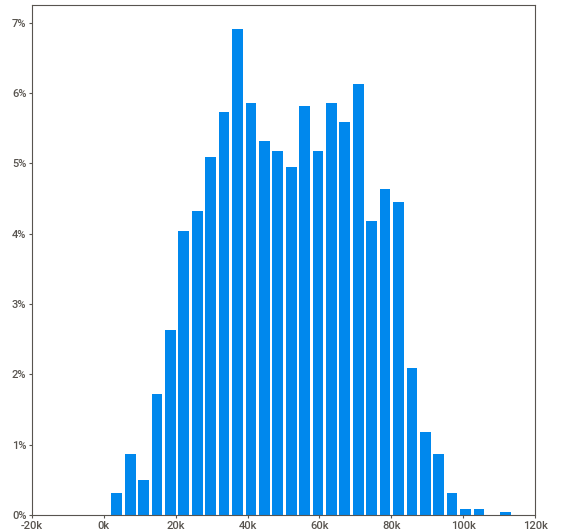
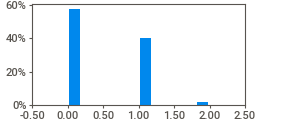
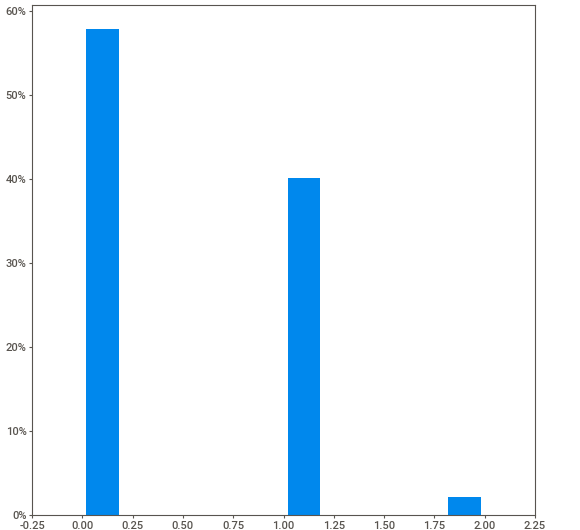
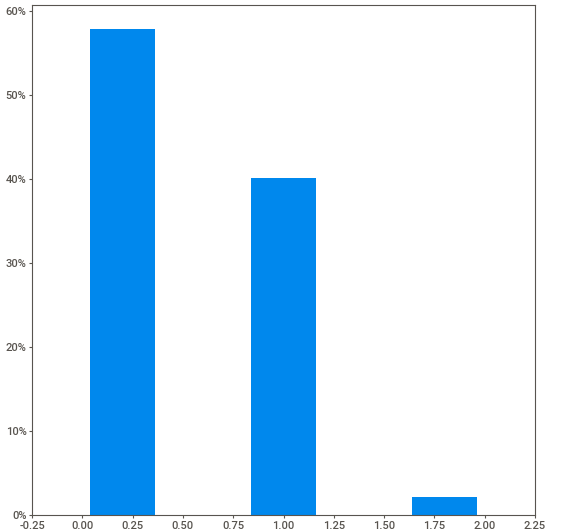
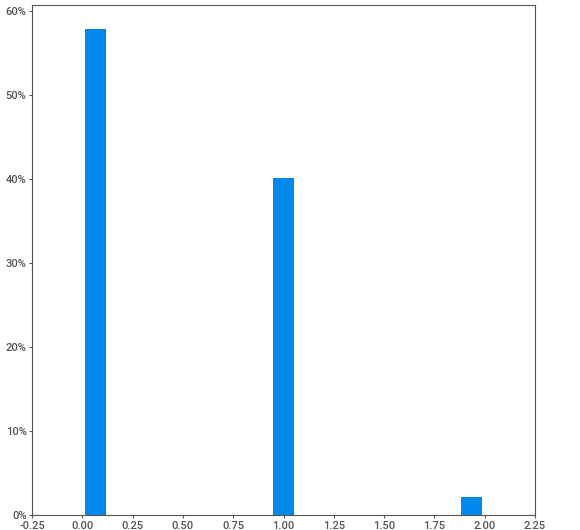
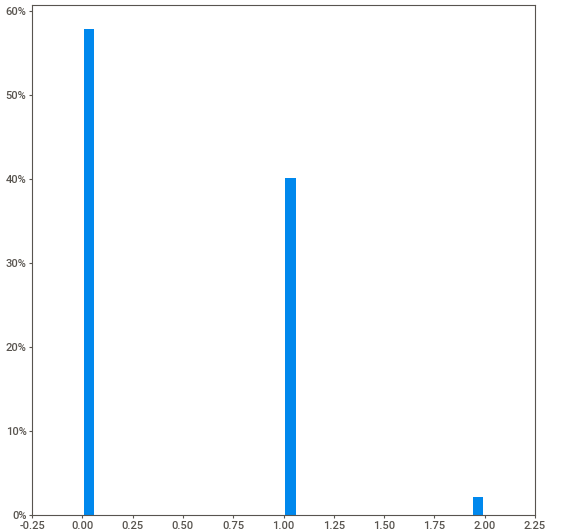
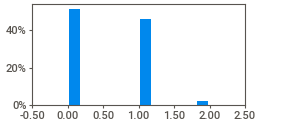
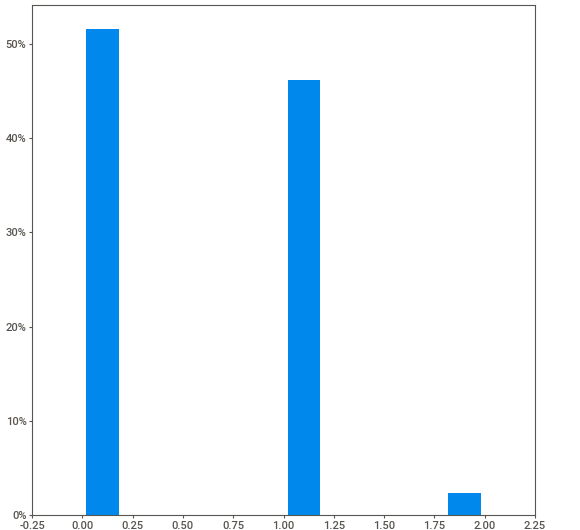
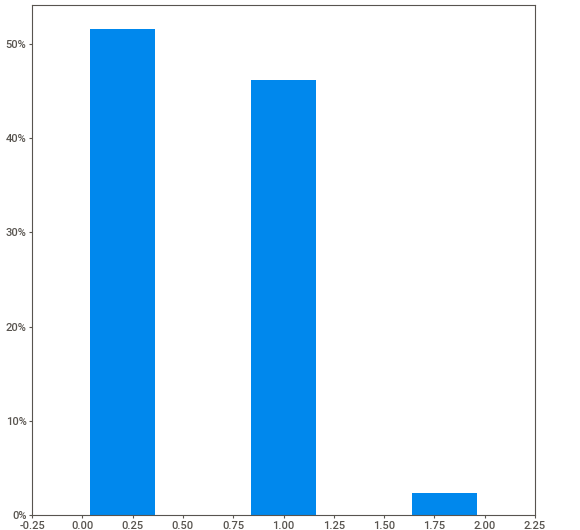
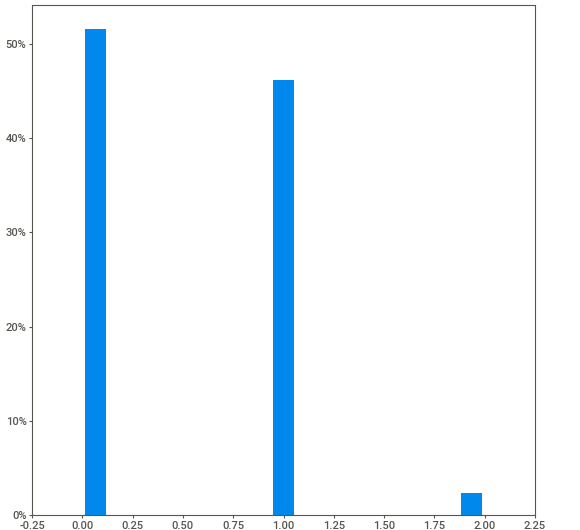
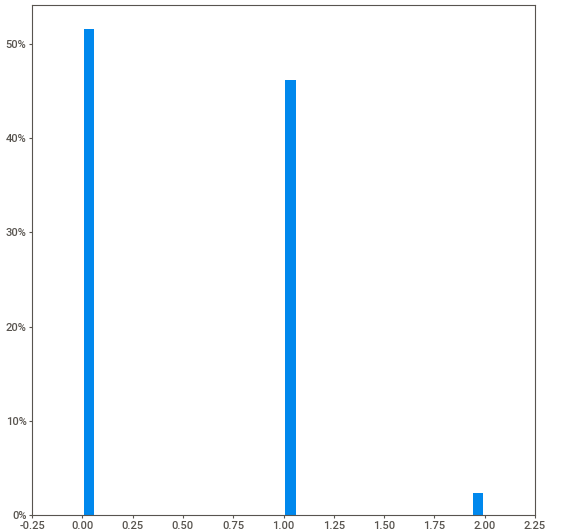
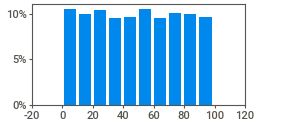
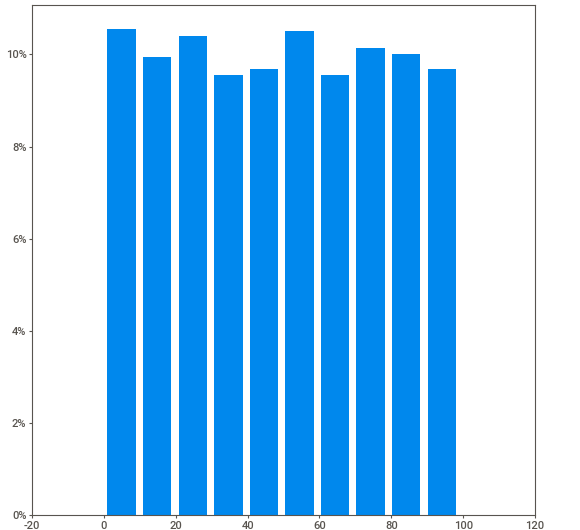
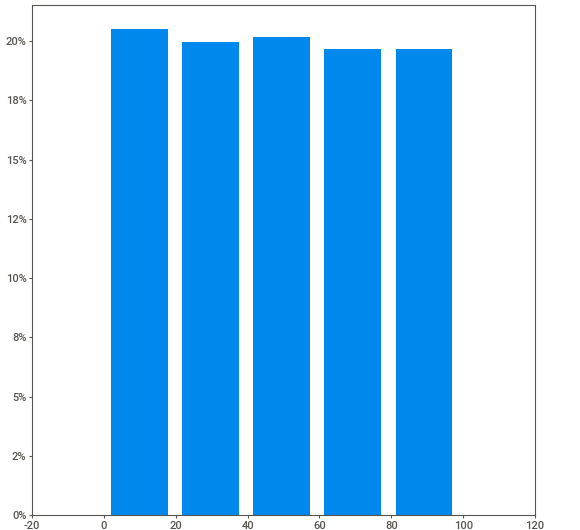
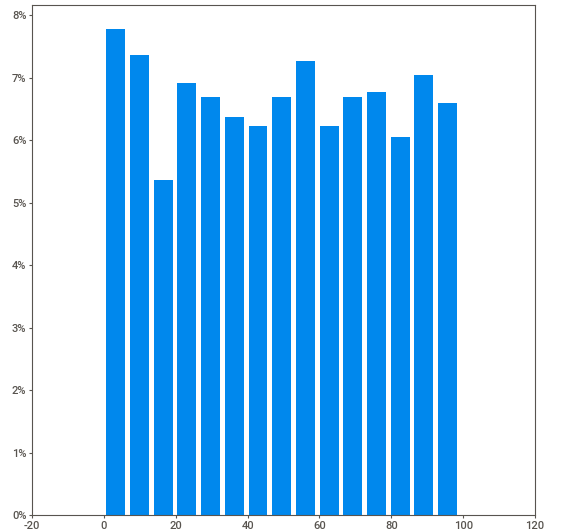
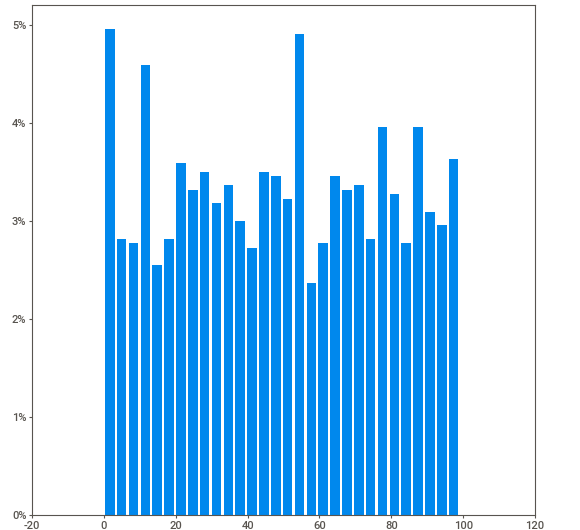
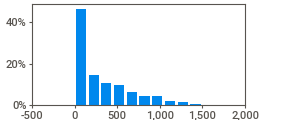
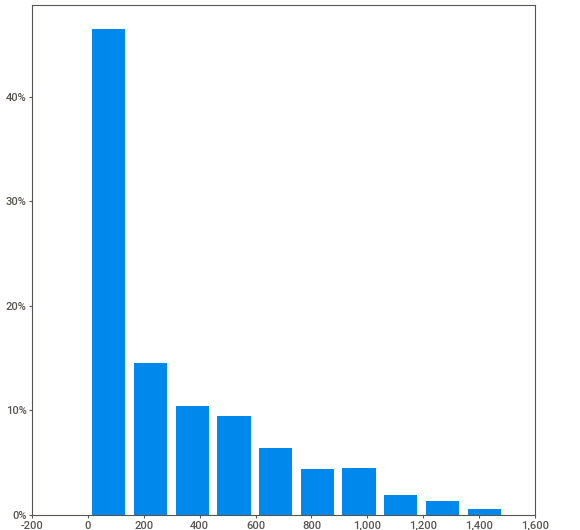
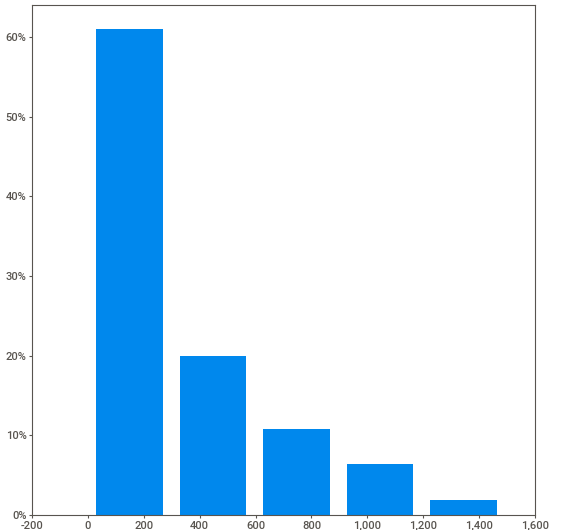
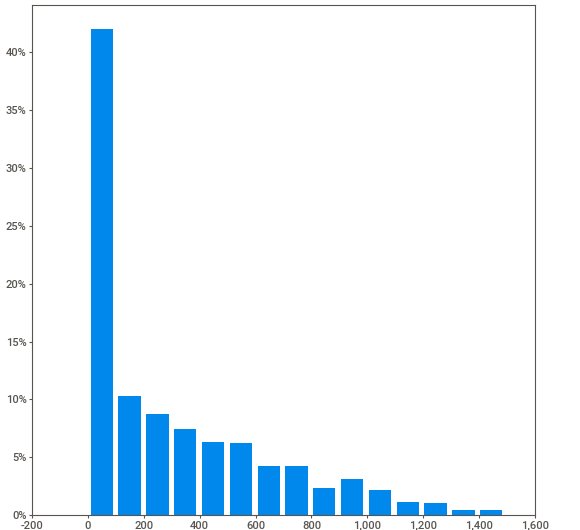
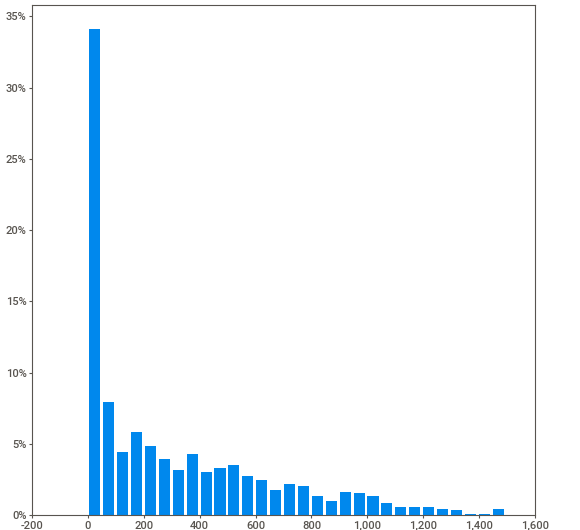
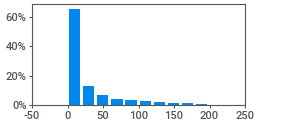
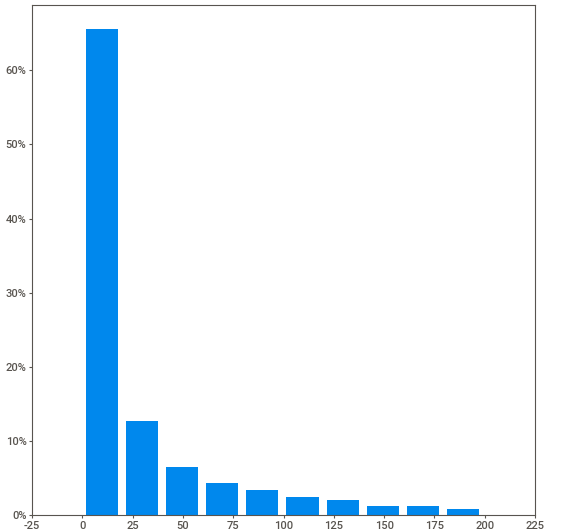
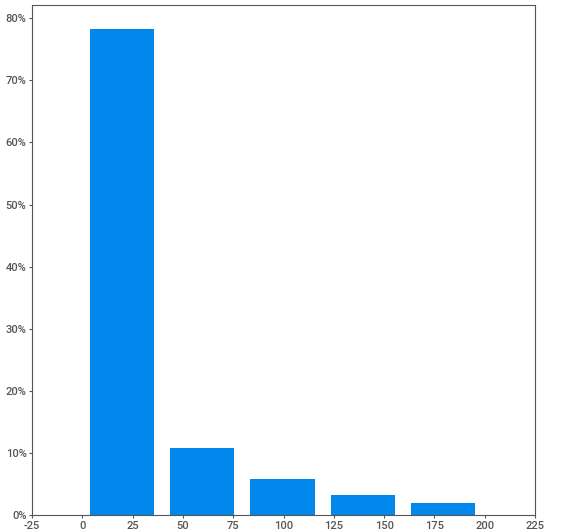
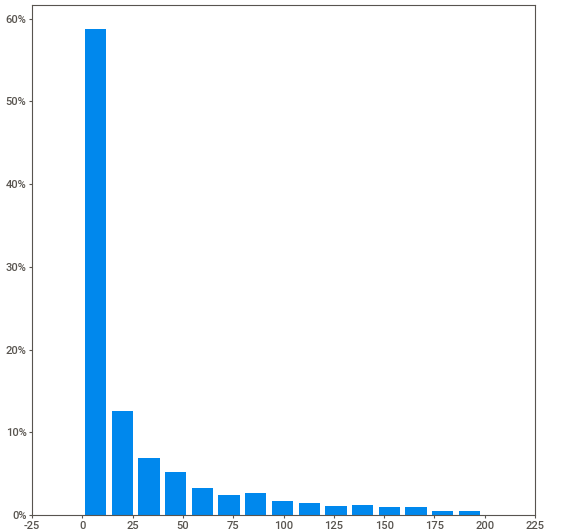
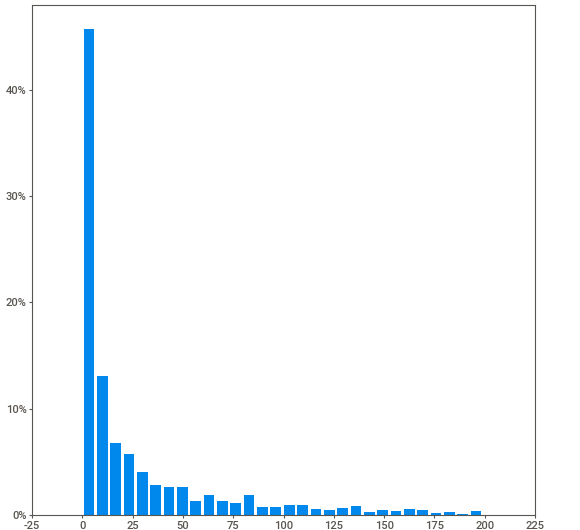
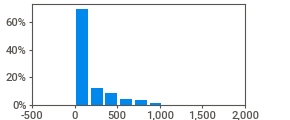
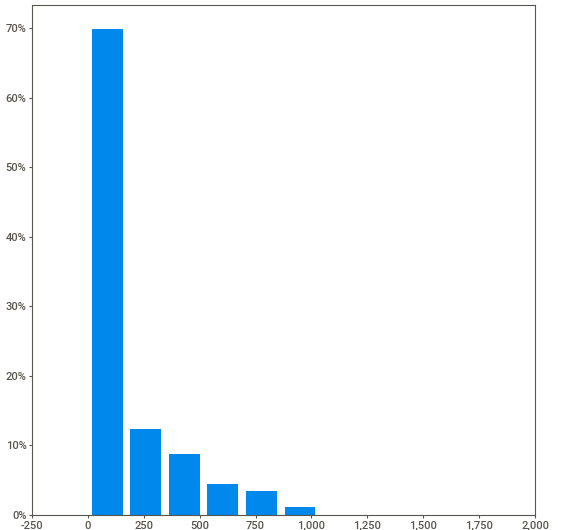
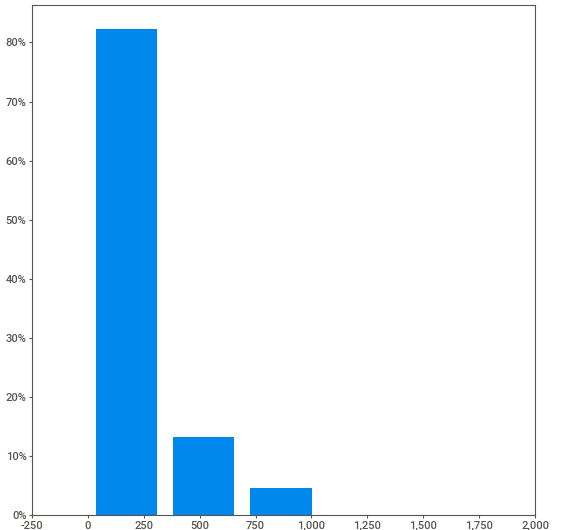
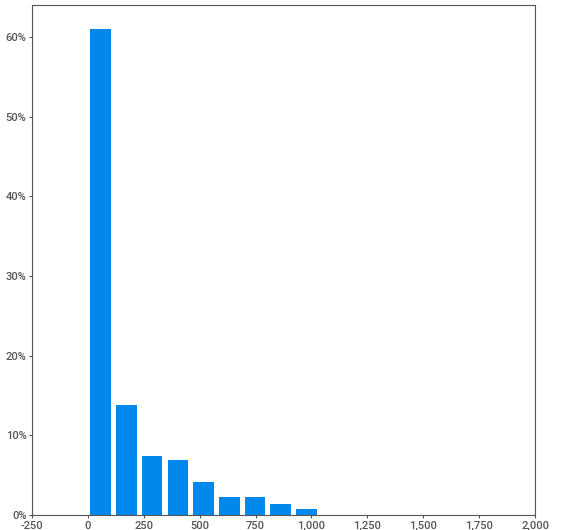
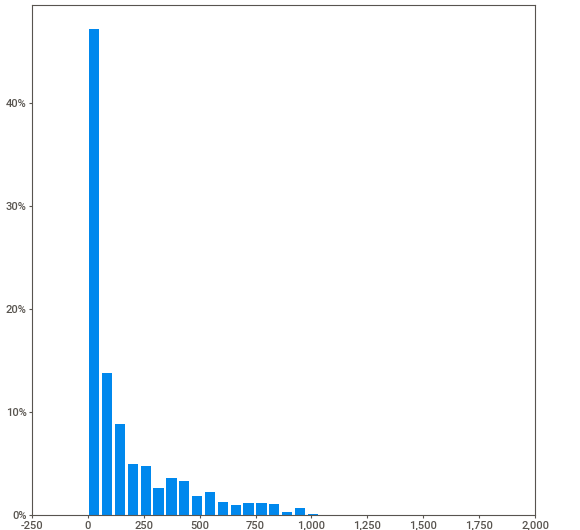
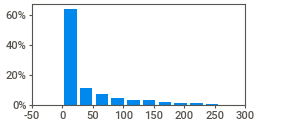
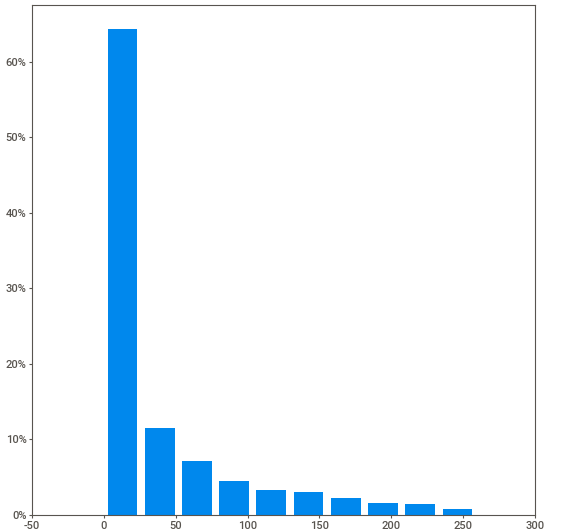
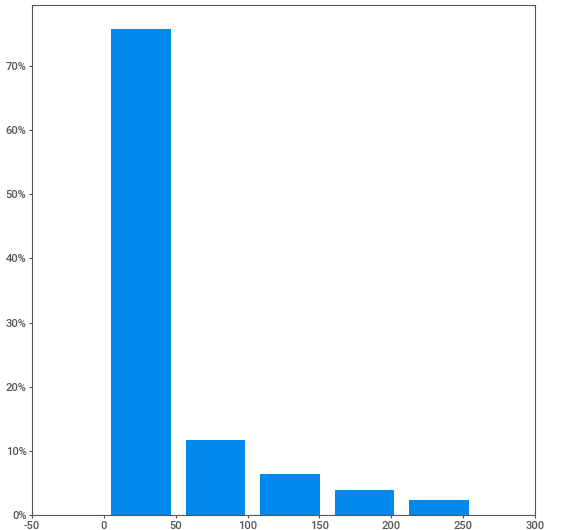
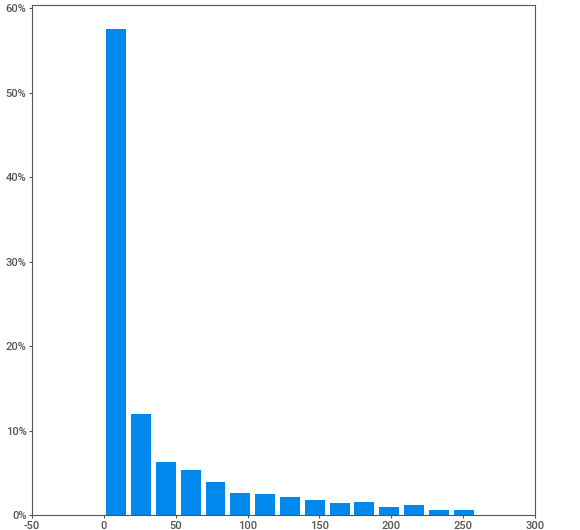
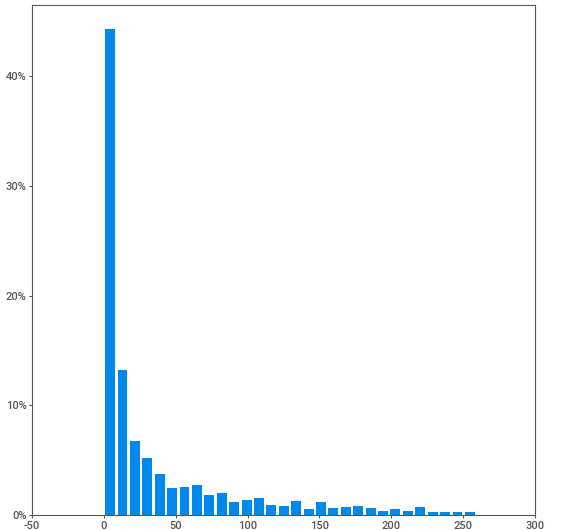
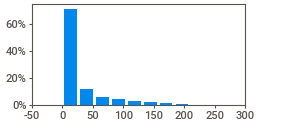
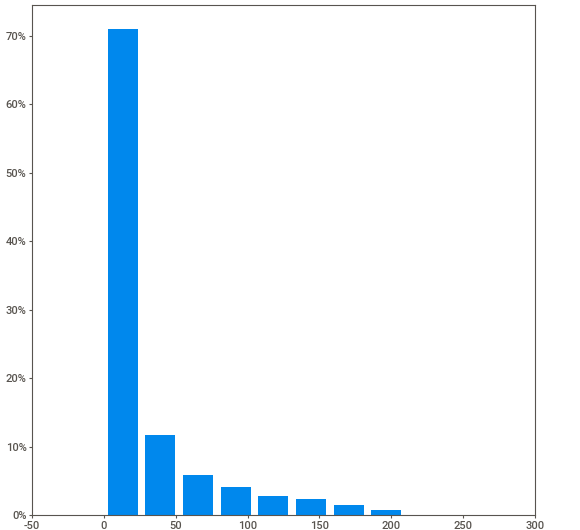
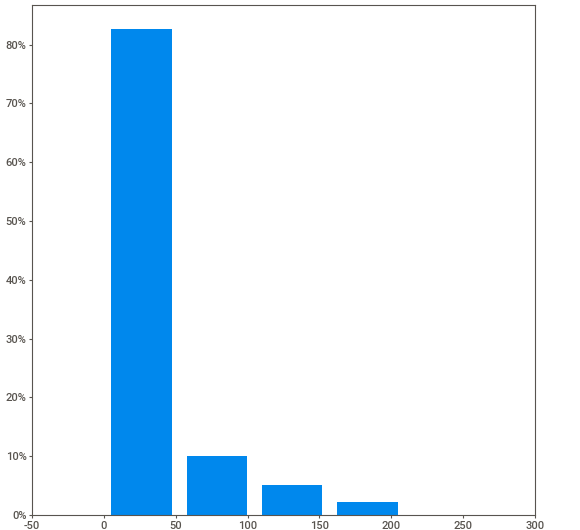
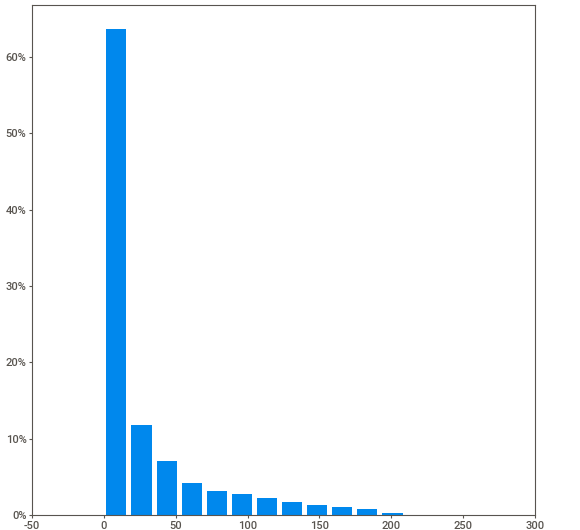
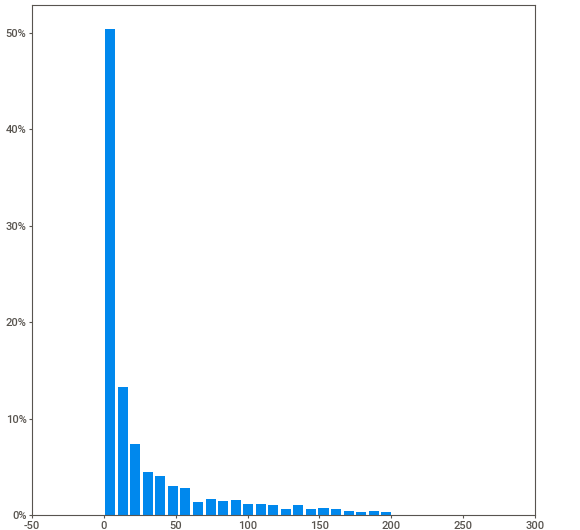
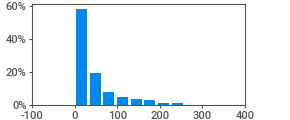
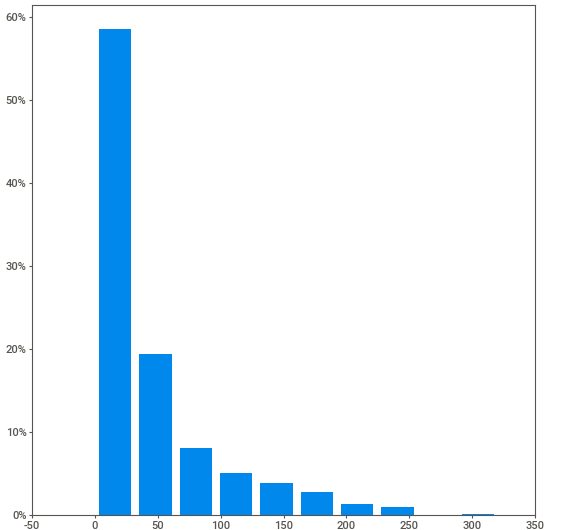
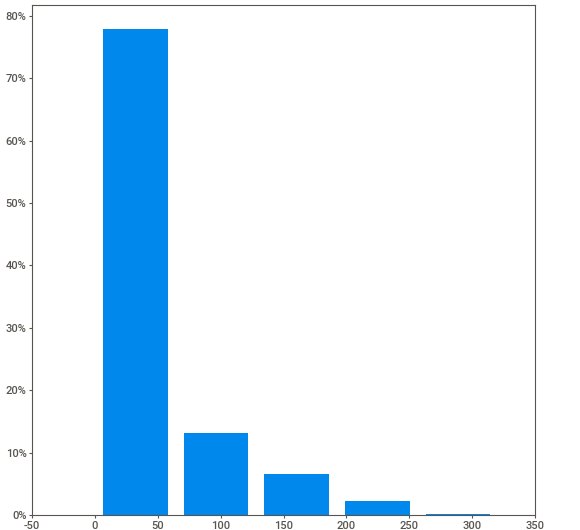
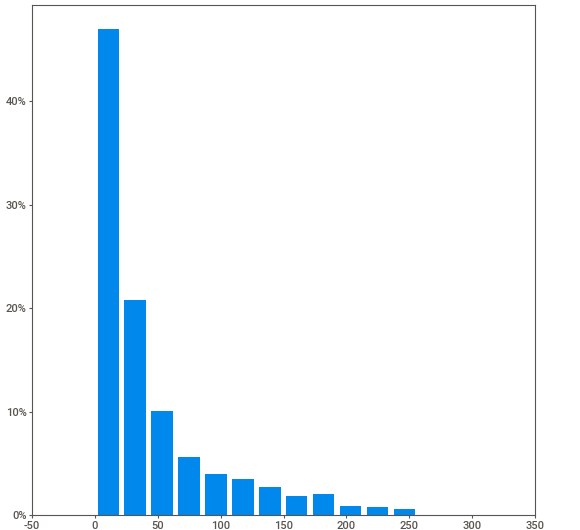
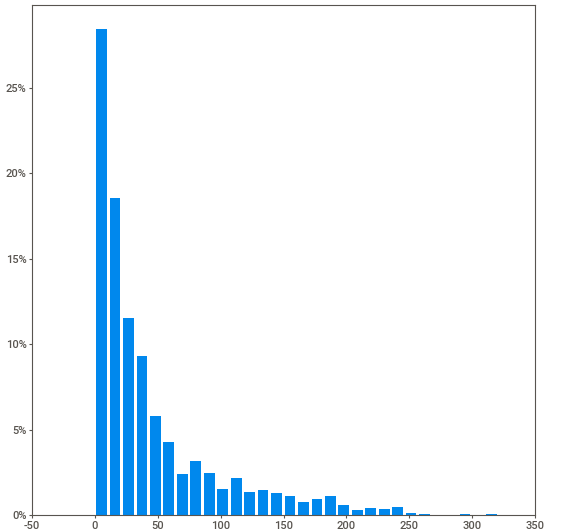
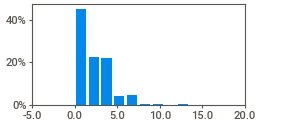
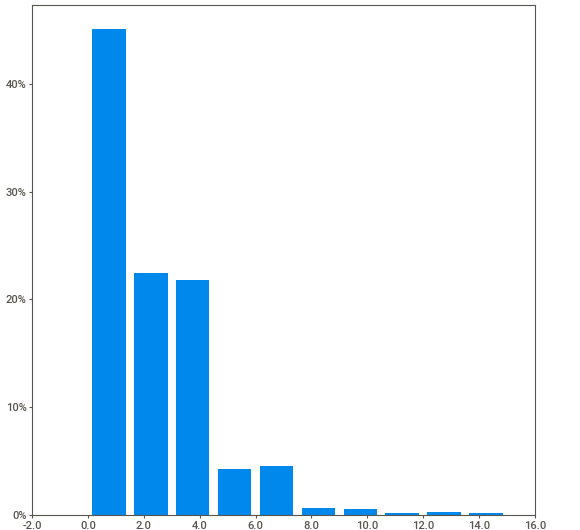
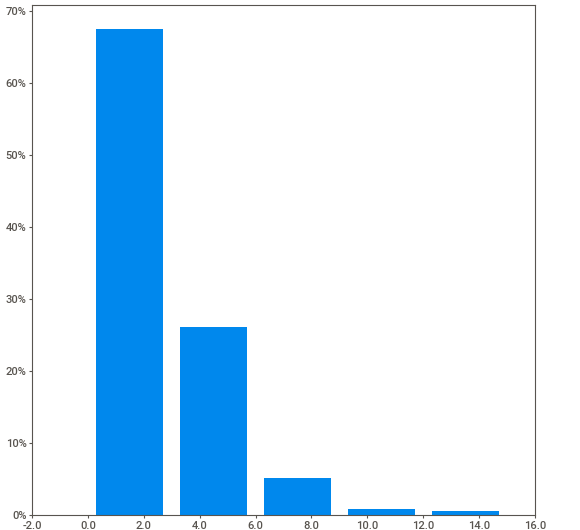
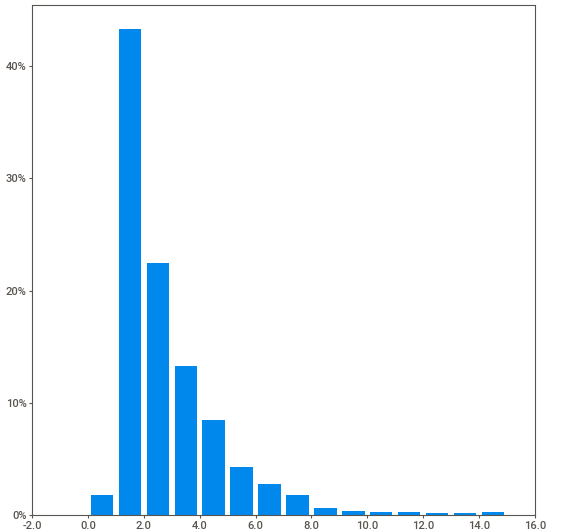
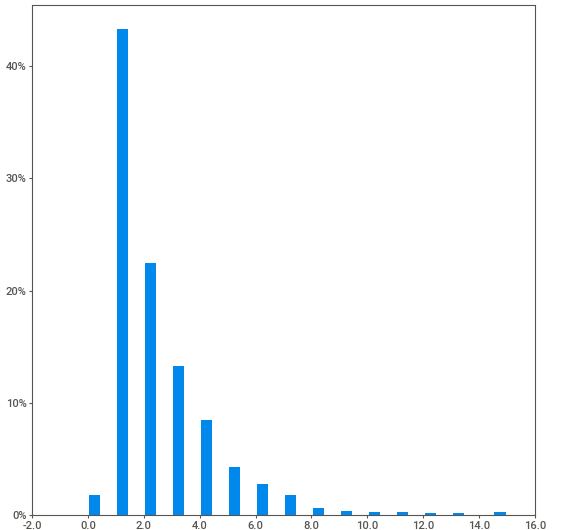
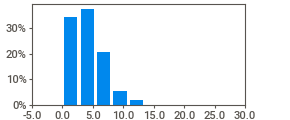
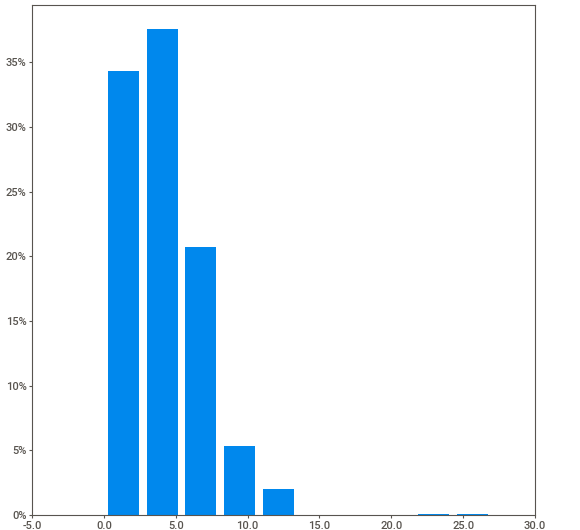
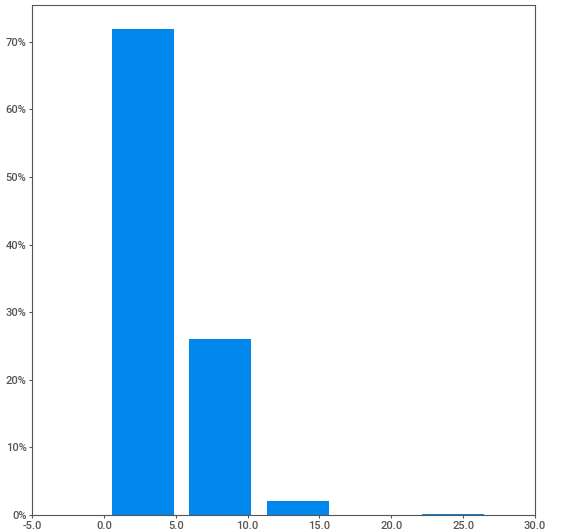
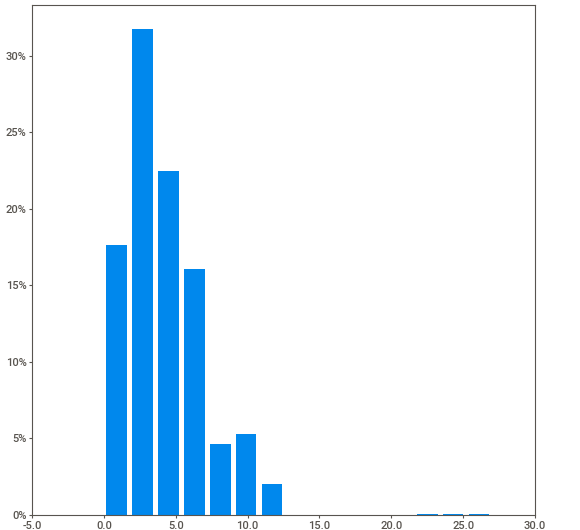
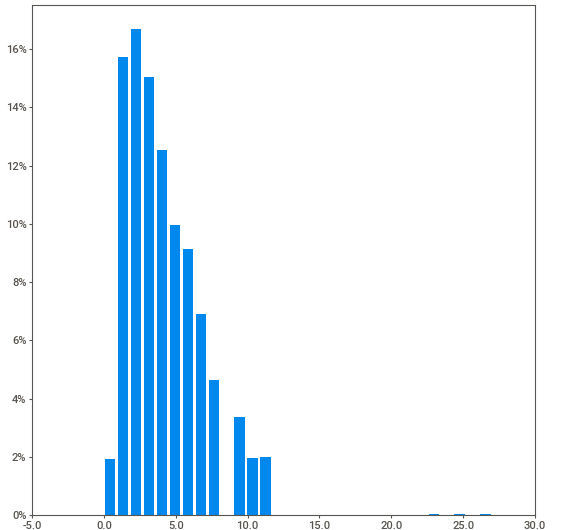
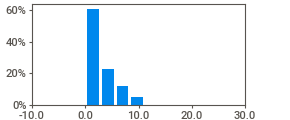
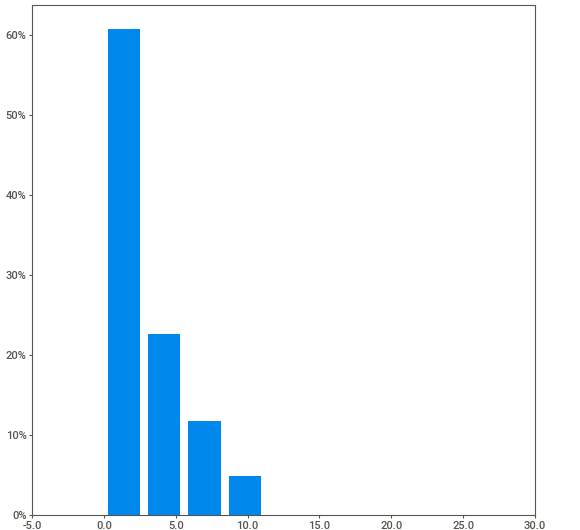
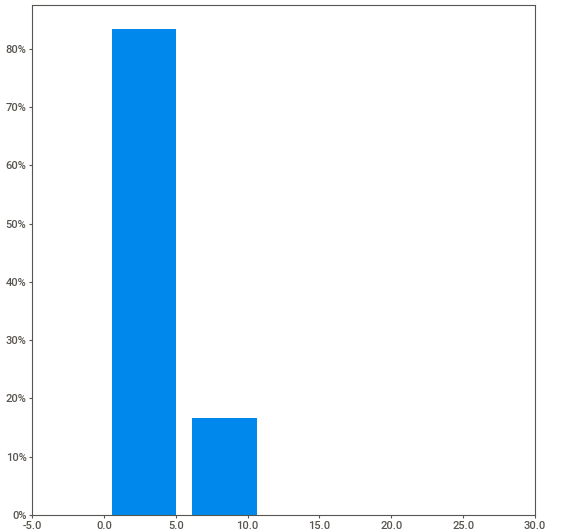
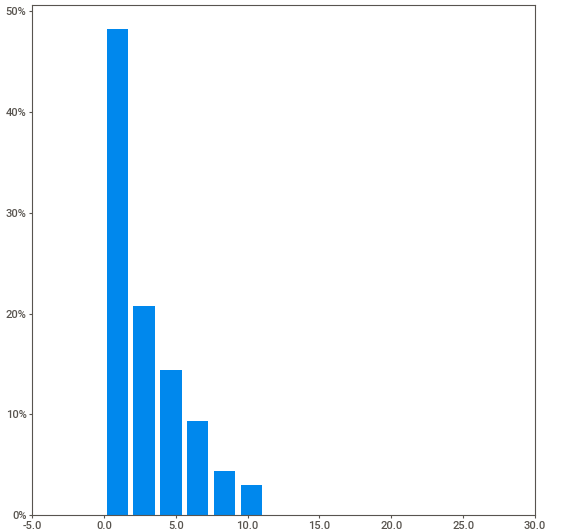
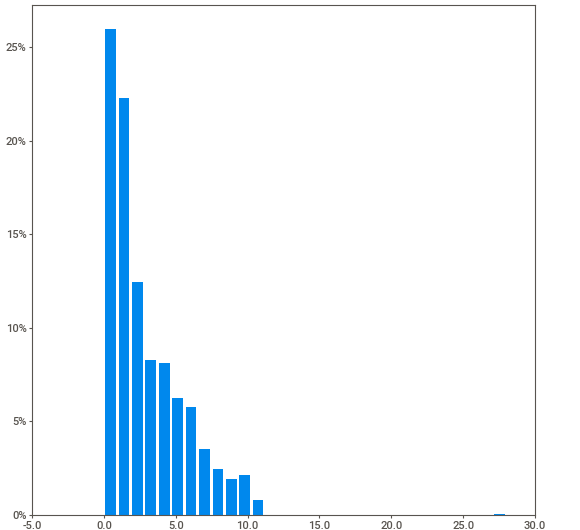
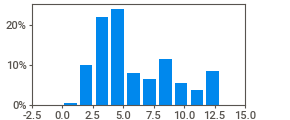
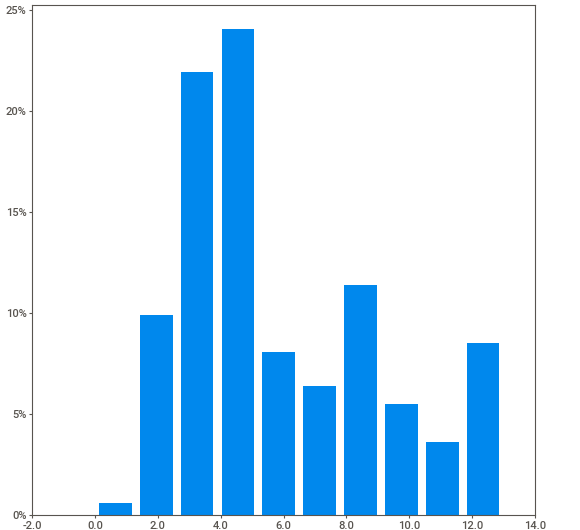
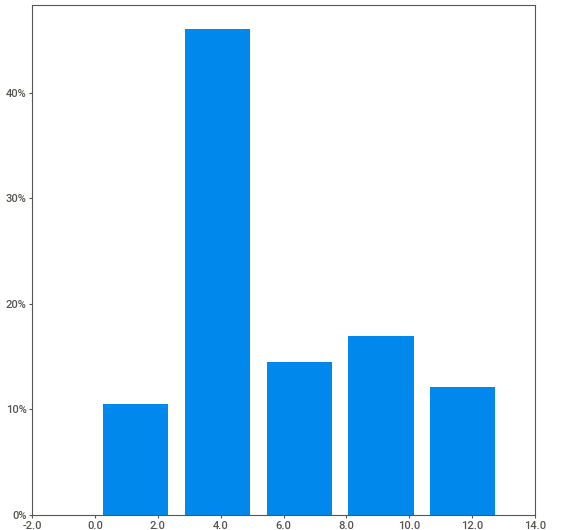
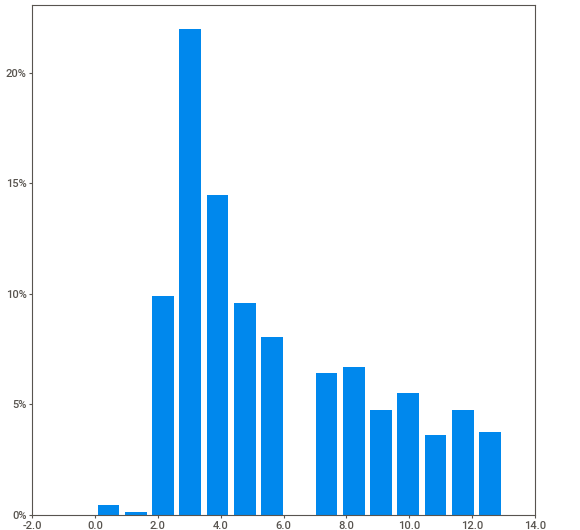
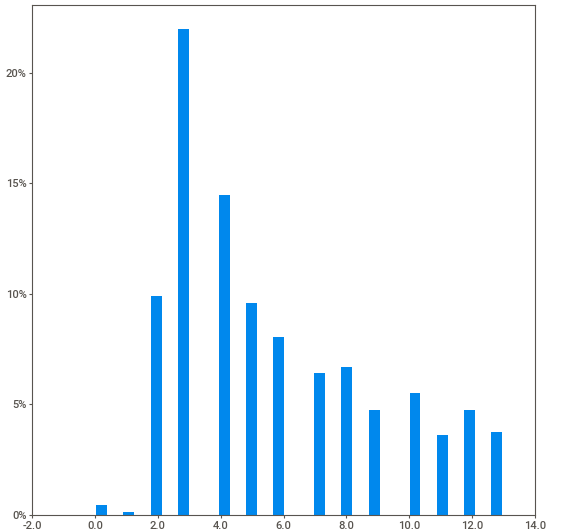
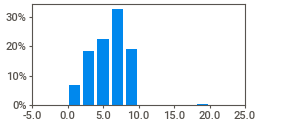
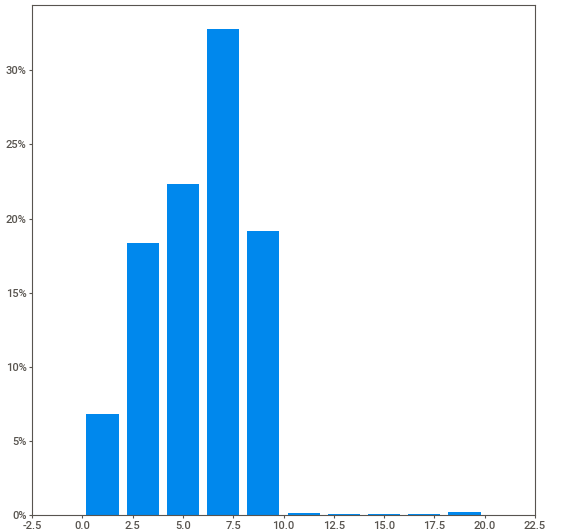
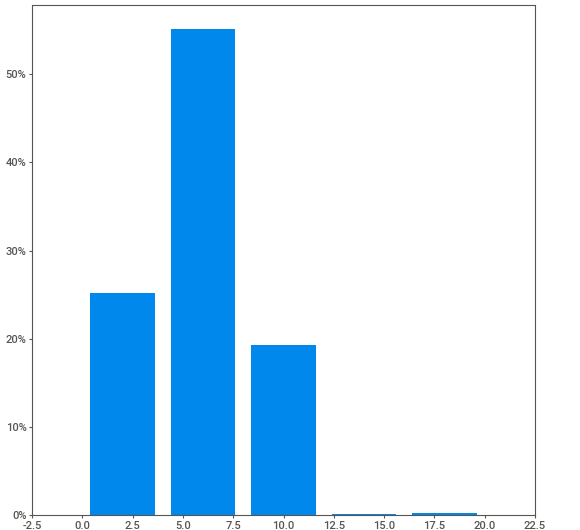
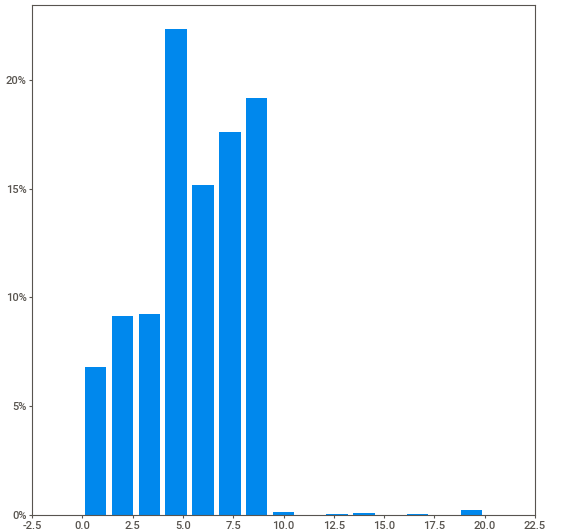
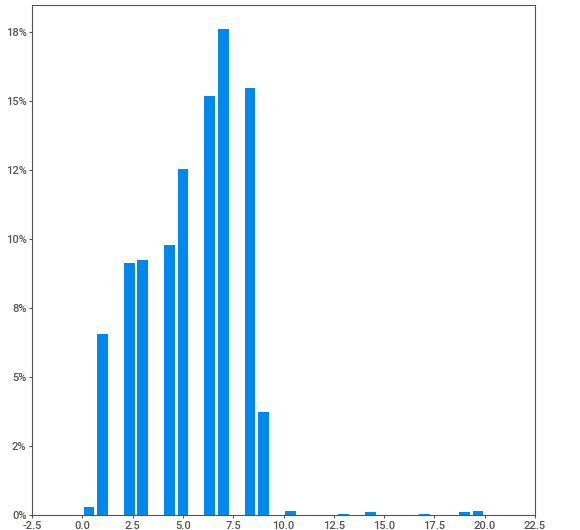
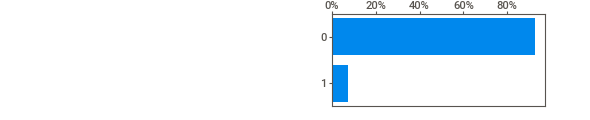
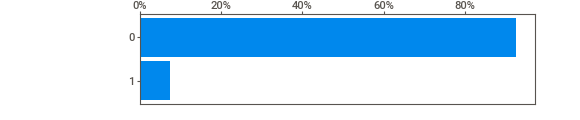
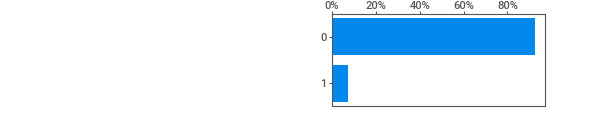
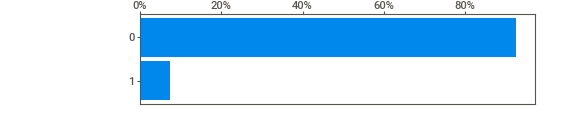
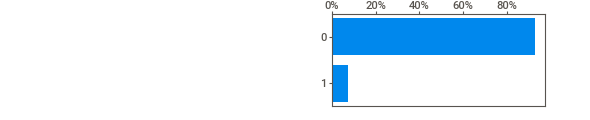
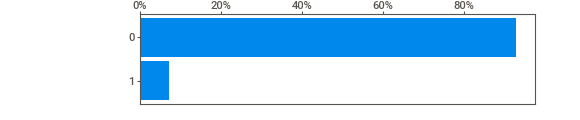
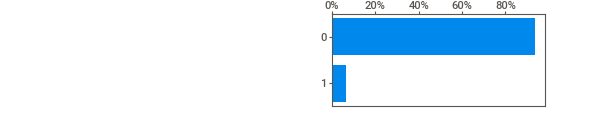
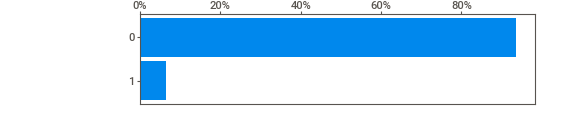
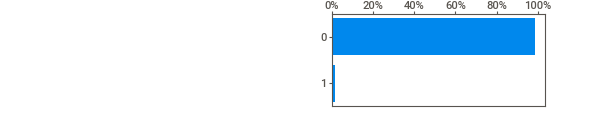
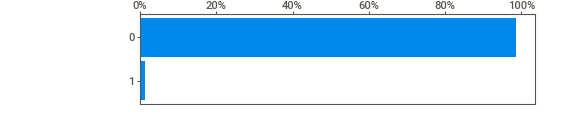
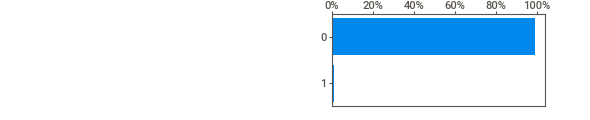
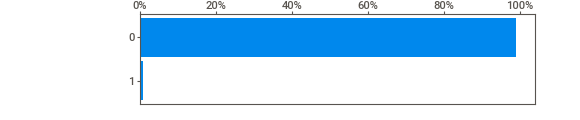
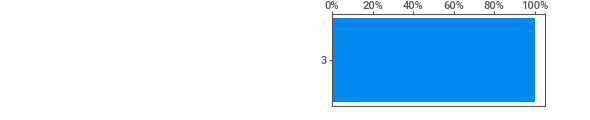
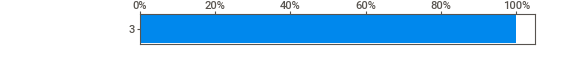
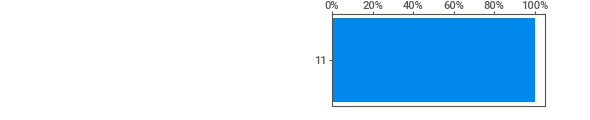
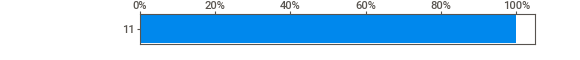
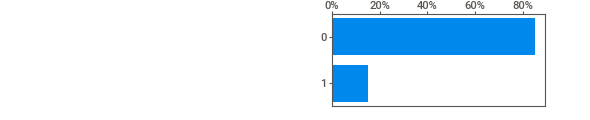
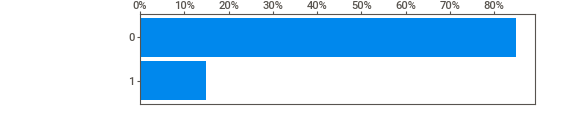
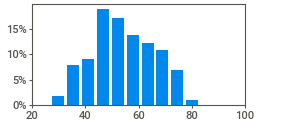
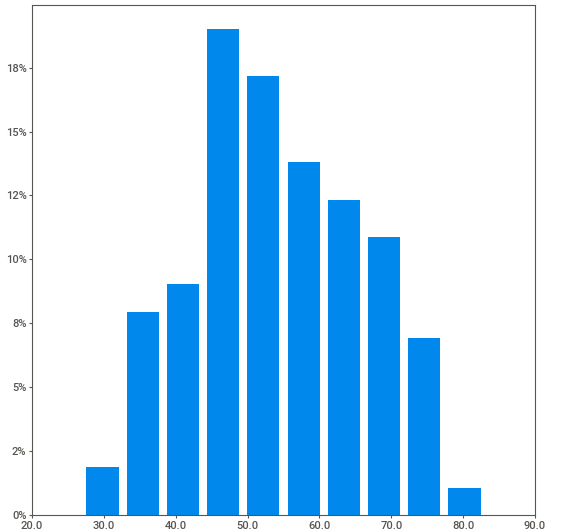
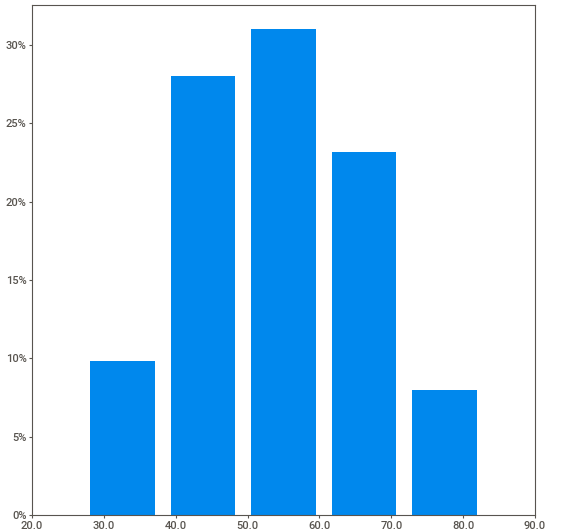
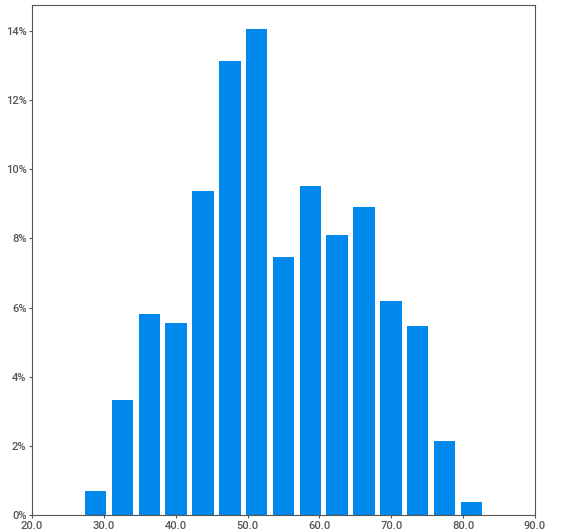
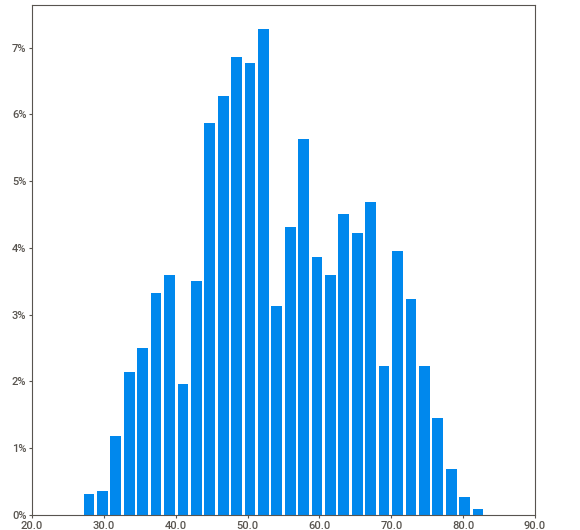
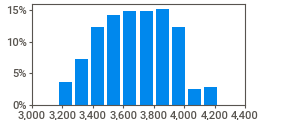
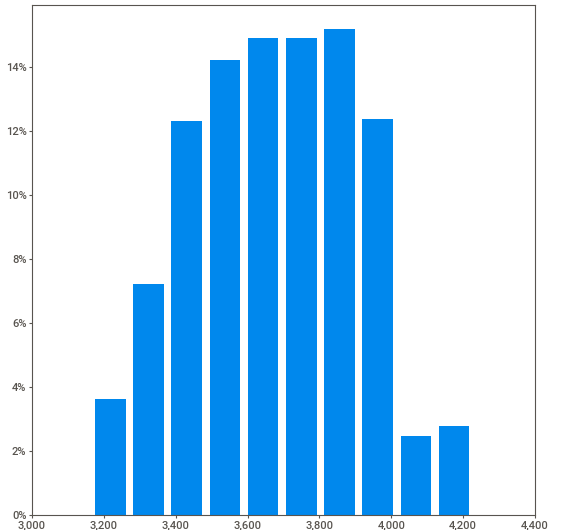
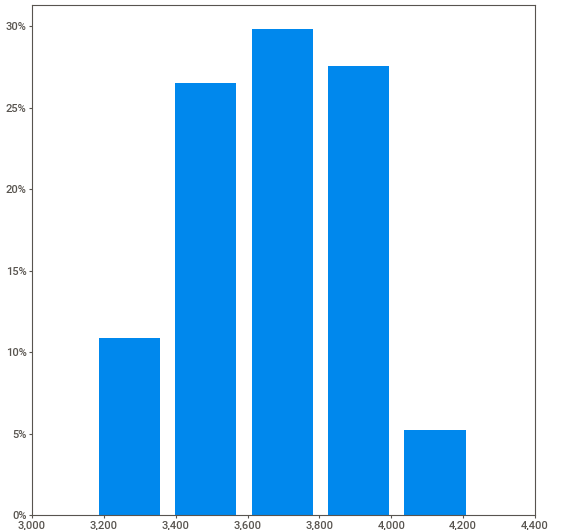
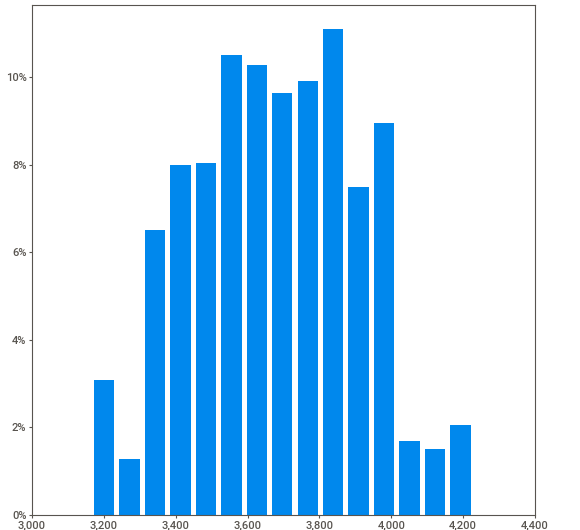
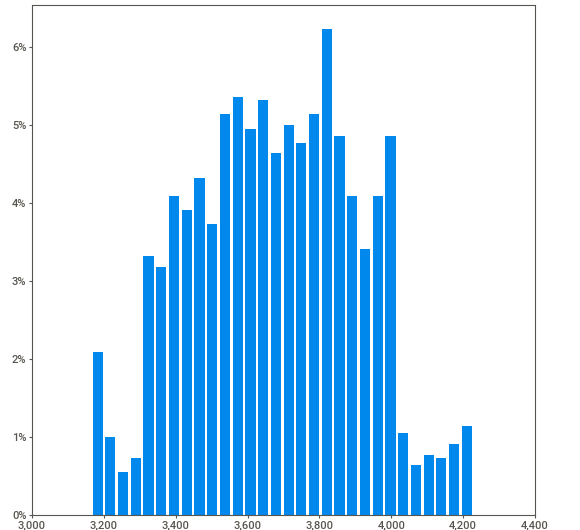
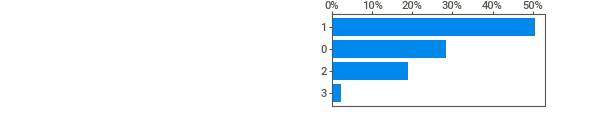
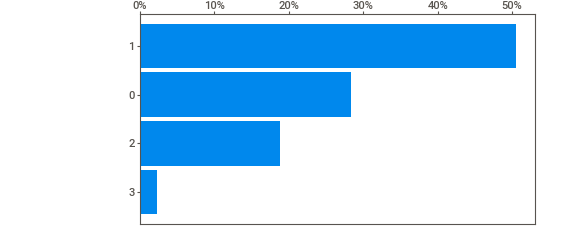
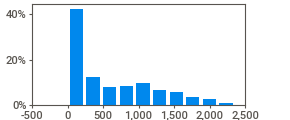
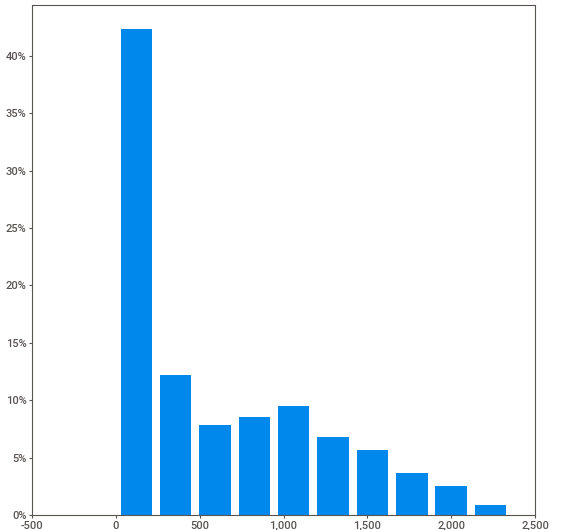
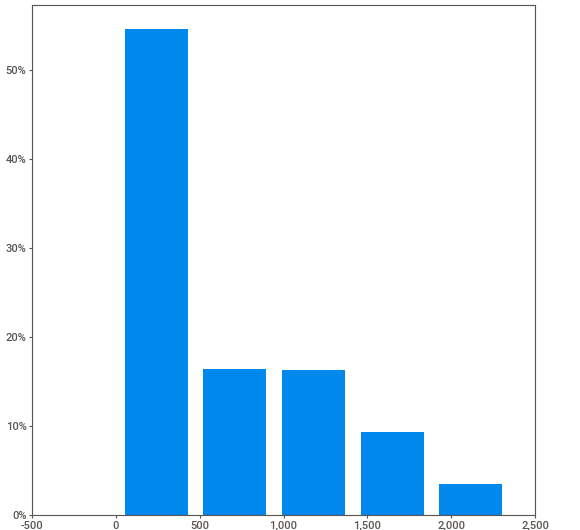
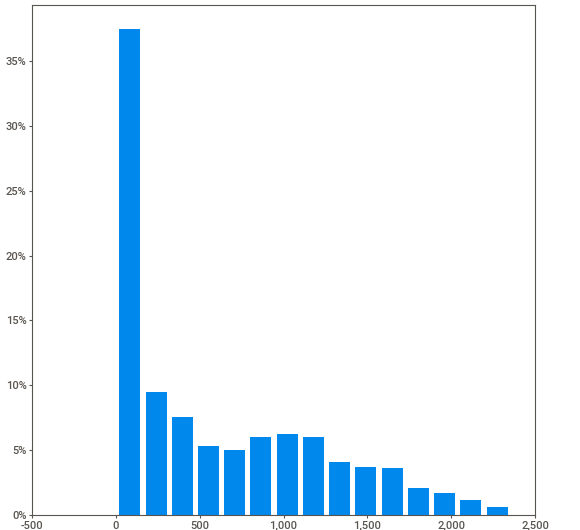
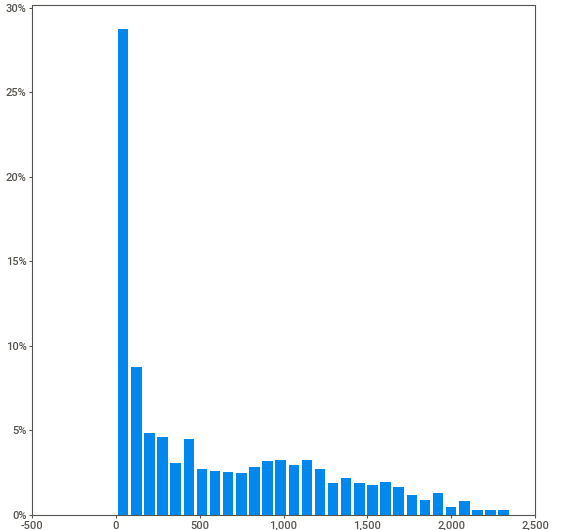
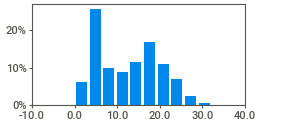
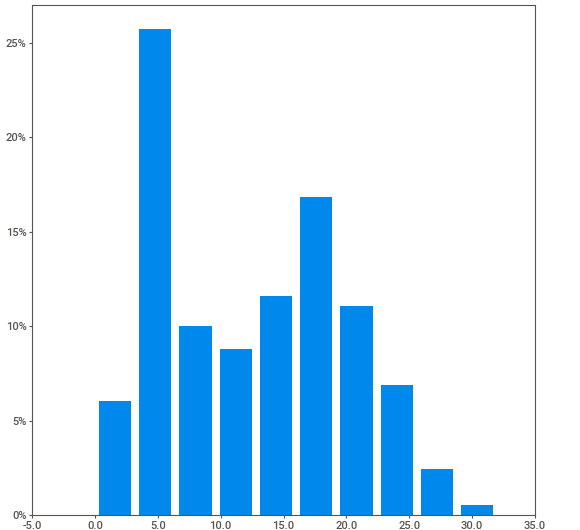
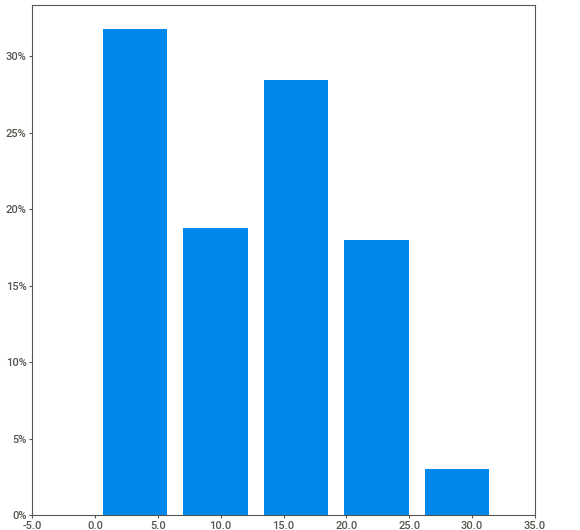
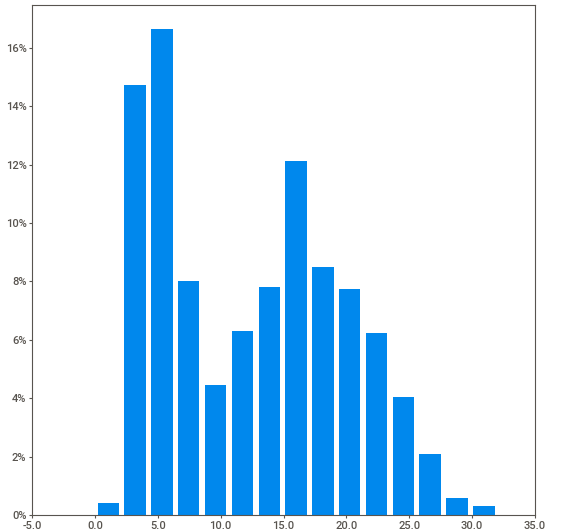
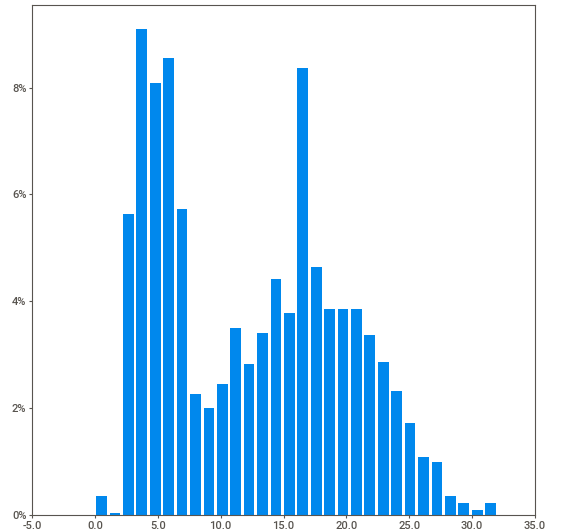
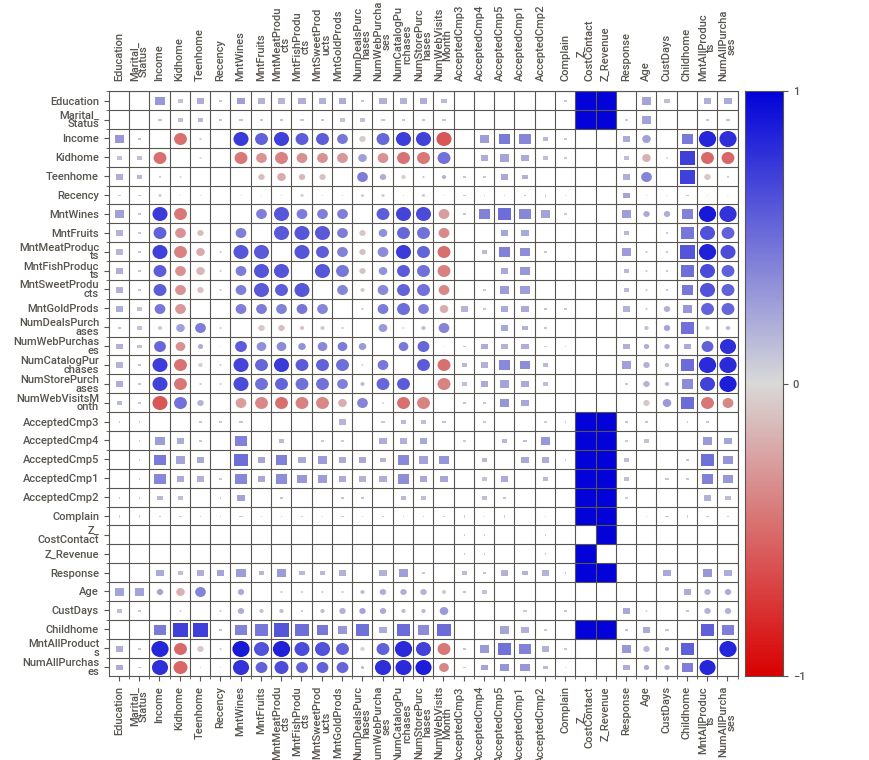
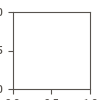

In [21]:
feat_cfg = sw.FeatureConfig(force_num=['Kidhome', 'Teenhome'])
sw.analyze(df.iloc[:, :32], feat_cfg = feat_cfg).show_notebook()

***Q1. Put your comprehensive report of the dataset and state some of the important findings?***


The raw data seems to be relatively tidy with only few missing values and outliers. It consists of 2240 rows and 29 features of multiple types: numerical, categorical, and datetime. Almost all features are complete and have no missing values, except for "Income". Specifically, there are 24 users whose income information are missing. At a glance, there doesn't seem to be any pattern that may explain these missing values. Each user seems to be unique enough compared to others which should make it fine for us to just remove these users from the data. Additionally, we also remove some outliers from the raw data. These outliers, while are part of reality, will certainly affect any analysis to be made. Removal of these missing values and outliers should help us in building a better analysis.

Let's first try to look into the customer base of this business. Based on the data, it seems that the average customer is currently in his/her fifties, well-educated, has been a customer for some time, and has a family (or at least living together with another person). These characteristics are nice to have for a business since this type of customer is relatively insensitive to changes in price due to having high income and willing to spend money on more expensive, nutritious, and complementary items.

A deeper look into the type of items purchased shows that our customers seem to prefer meat and wine products. It is not just because of the total and average amount spent, but also on the fact that almost all of them have made a purchase on those products, with only 1 user who has not purchased meat and 13 customers who have not purchased wine out of 2216 total customers. Our customers have spent a total of around 370.000 on meat and 676.000 on wine, which combined accounts for almost 80% of total amount spent. As such, it should be noted that this business has a high dependency on these two products.

Further breakdown on where purchases are done, the data shows that customers still prefer the purchasing experience of in-store purchase over the conveniences provided by other purchase channels. In-store purchase accounts for almost half of all purchases made by our customers, with web purchase on second place with 32% and catalog purchase rounding up the remaining. Although web purchase is not the preferred channel, its adoption is not too far off. It is a surprise considering the customers' demographic and could be indicative that they are adaptive to the technology and present opportunities for us to launch some initatives and campaigns on the website.

In [6]:
df.describe().T[['mean']]

,mean
Income,51551.321364
Kidhome,0.443182
Teenhome,0.507727
Recency,49.007727
MntWines,304.005909
MntFruits,26.255909
MntMeatProducts,163.809091
MntFishProducts,37.606364
MntSweetProducts,26.950455
MntGoldProds,43.891364


<Axes: title={'center': 'Customer by Education'}, xlabel='Percentage'>

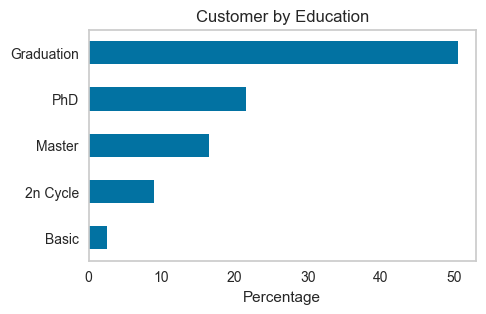

In [7]:
(
    df['Education']
    .value_counts(normalize=True).mul(100).round(1)
    .sort_values(ascending=True)
    .plot.barh(xlabel='Percentage', figsize=(5, 3), grid=False, title='Customer by Education')
)

<Axes: title={'center': 'Customer by Marital Status'}, xlabel='Percentage'>

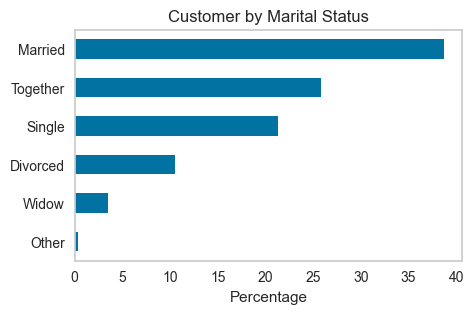

In [8]:
(
    df['Marital_Status']
    .value_counts(normalize=True).mul(100).round(1)
    .sort_values(ascending=True)
    .plot.barh(xlabel='Percentage', figsize=(5, 3), grid=False, title='Customer by Marital Status')
)

<Axes: title={'center': 'Customer by Age Group'}, xlabel='Percentage'>

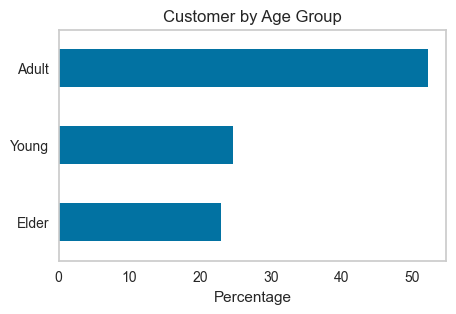

In [9]:
(
    df['AgeGroup']
    .value_counts(normalize=True).mul(100).round(1)
    .sort_values(ascending=True)
    .plot.barh(xlabel='Percentage', figsize=(5, 3), grid=False, title='Customer by Age Group')
)

***Q2. What type of customer is the most rewarding? What are they buying and how they behave?***


While we have described the average characteristics and preferences of the overall customers, they still can be further clustered into smaller groups who each has its own unique attributes. They can be clustered based on their profiling features (education, marital status, age, etc) and transaction features (amount spent, number of purchases, etc). Profiling features are features related to the characteristics of the customer, which are relatively harder to change and influenced. Meanwhile, transaction features are more fluctuative and can be influenced since they are related to amount and number of purchases. 

Clusters are built using a combination of profiling features. Since there are multiple of such features, each with its own unique value, there will be multiple clusters that will be created. Ultimately, each cluster will has its own value and importance. Determining the most important cluster can be done through two ways: looking at the sum or looking at the average. The former means that cluster who has the highest total purchases amount is the most important. While the latter looks at how much each customer purchases on each cluster. 

The first graph below shows the top 10 clusters based on total purchases amount. We can see that the top cluster is customers who are of adult age group (between 45 and 64 years old), on "Graduation" education level, and are married. This cluster is a combination of the most common profiling features. As such, it is unsurprising that it becomes the business' most important cluster. Also thanks to its size, this cluster becomes the biggest purchaser of all type of products.

However, if we look on the average, it seems that the Adult - Graduation - Married cluster is not even the top 10 clusters. Instead, the most important cluster now is customers who are Young (less than 45 years old), has a PhD, and are divorced. They purchases significantly higher amount of wine and meat than the other clusters. However, as expected, there is only 1 user in that cluster which undoubtedly inflate the number for the cluster.

Based on this information, I would argue that customers who belong in the Adult - Graduation - Married cluster are the most rewarding. They are the biggest cluster of the bunch and has the highest purchases amount which mostly is spent on wine and meat. Additionally, there is not any significant behavioral difference between each top clusters. They all prefer meat and wine than other products.

In [51]:
(
    df
    .assign(
        Cluster = lambda x: x.AgeGroup.astype(str) + " - " + x.Education.astype(str) + " - " + x.Marital_Status.astype(str)
    )
    .groupby('Cluster')['Cluster']
    .count()
    .sort_values(ascending=False)
)

Cluster
Adult - Graduation - Married     226
Adult - Graduation - Together    140
Young - Graduation - Married     120
Adult - Graduation - Single      118
Adult - PhD - Married            111
                                ... 
Adult - Basic - Single             1
Young - Graduation - Widow         1
Adult - Basic - Divorced           1
Young - PhD - Divorced             1
Elder - Basic - Married            1
Name: Cluster, Length: 71, dtype: int64

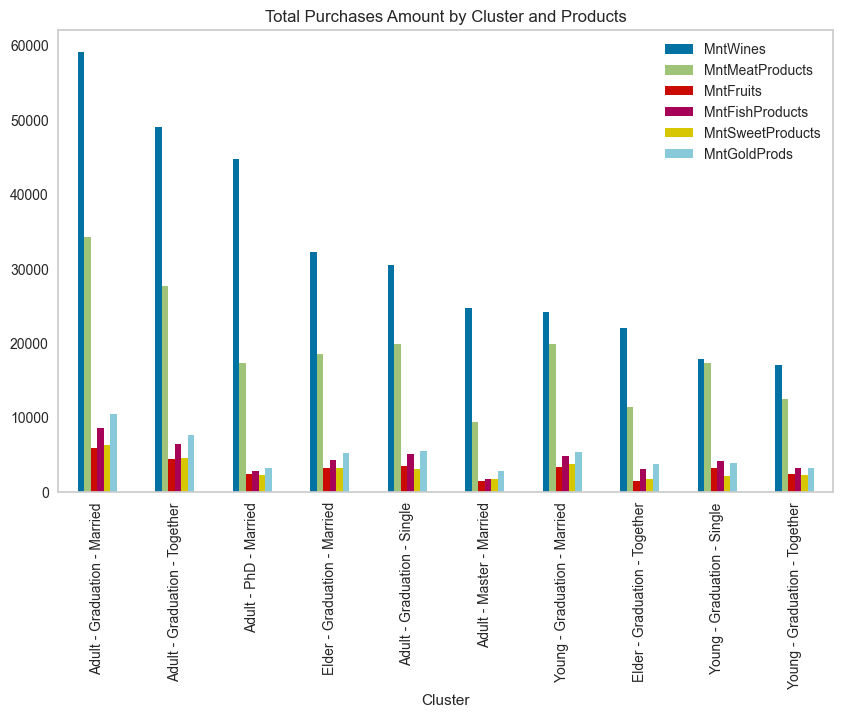

In [11]:
cluster_df_sum =\
(
    df
    .assign(
        Cluster = lambda x: x.AgeGroup.astype(str) + " - " + x.Education.astype(str) + " - " + x.Marital_Status.astype(str)
    )
    .groupby('Cluster')
    .agg('sum')
    .sort_values('MntAllProducts', ascending=False)
    .reset_index()
)

create_plot(
    cluster_df_sum.head(10),
    ['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
    'Cluster',
    'Total Purchases Amount by Cluster and Products'
)


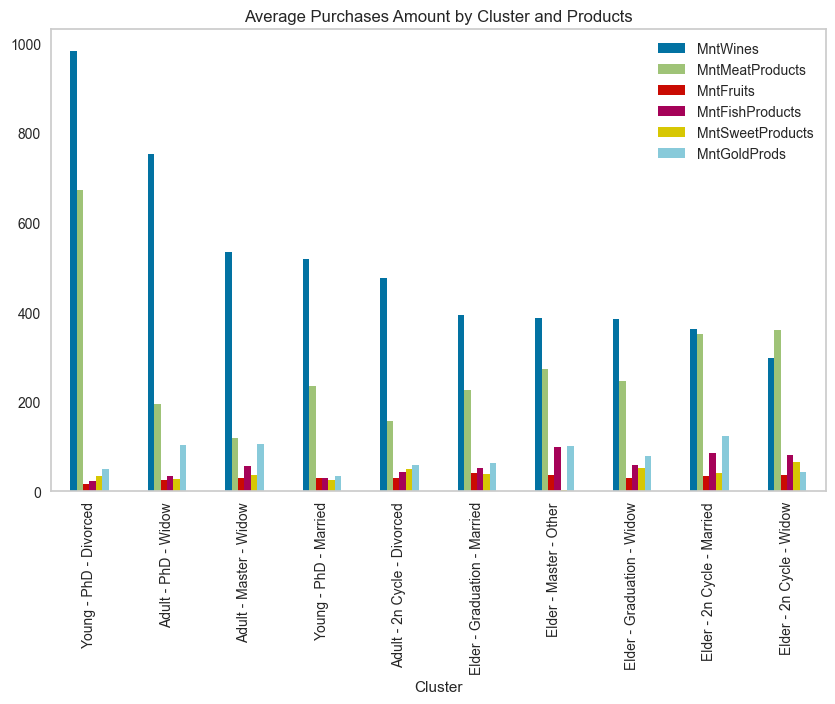

In [12]:
cluster_df_avg =\
(
    df
    .assign(
        Cluster = lambda x: x.AgeGroup.astype(str) + " - " + x.Education.astype(str) + " - " + x.Marital_Status.astype(str)
    )
    .groupby('Cluster')
    .agg('mean')
    .sort_values('MntAllProducts', ascending=False)
    .reset_index()
)

create_plot(
    cluster_df_avg.head(10),
    ['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
    'Cluster',
    title='Average Purchases Amount by Cluster and Products'
)


***Q3. What are your recommendations to your previous EDA?***


As a business, any recommendations, campaigns, or promotions must be aimed to achieve one goal: to increase revenue. Based on the insights that we have found, I would argue that we need to focus our campaigns on customers who belong in the "Adult - Graduation - Married" cluster. Alongside the fact that this is our biggest cluster and has the highest purchases amount, we can also see that past campaigns had not generated much acceptance by this cluster. From the graph we can see that the most successful campaign so far for this cluster is the 4th campaign, and even this only got accepted by less than 8% of customers. This is somewhat surprising, considering the fact that other similar clusters, such as: "Adult - Graduation - Together" or "Adult - PhD - Married" both have a relatively higher rate. This could indicate that we have never ran a tailor-made campaign for this cluster. The proof for the statement is also presents on the second graph. While the acceptance rate of the last campaign is higher compared to the previous fives, it is still below the rate of the two similar clusters. 

Therefore, one recommendation that I would make is to design a campaign which revolve around the preferences and characteristics of our top cluster. Maybe we can run a sales campaign which revolves around the cluster's preference of wine and meat?

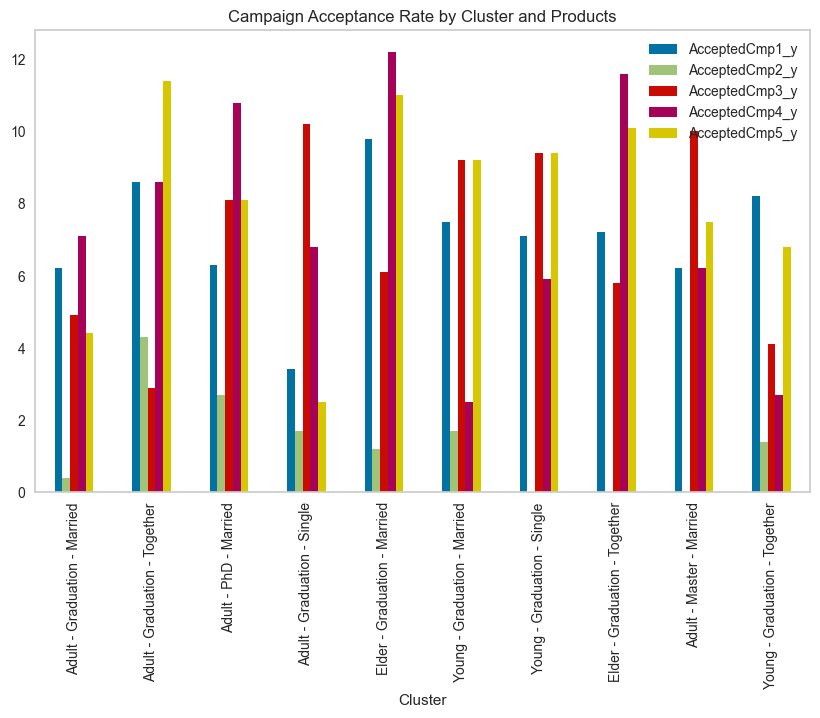

In [13]:
cluster_df = pd.merge(cluster_df_sum, cluster_df_avg, on='Cluster')

create_plot(
    cluster_df.head(10),
    ['AcceptedCmp1_y', 'AcceptedCmp2_y', 'AcceptedCmp3_y', 'AcceptedCmp4_y', 'AcceptedCmp5_y'],
    'Cluster',
    title='Campaign Acceptance Rate by Cluster and Products',
    sort='MntAllProducts_x',
    pct=True,
)

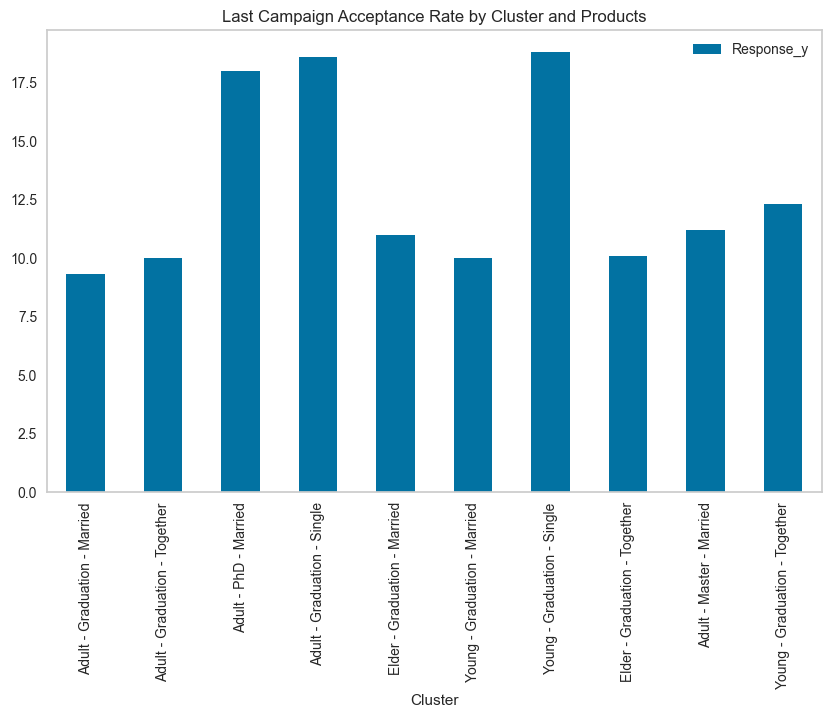

In [14]:
create_plot(
    cluster_df.head(10),
    ['Response_y'],
    'Cluster',
    title='Last Campaign Acceptance Rate by Cluster and Products',
    sort='MntAllProducts_x',
    pct=True,
)

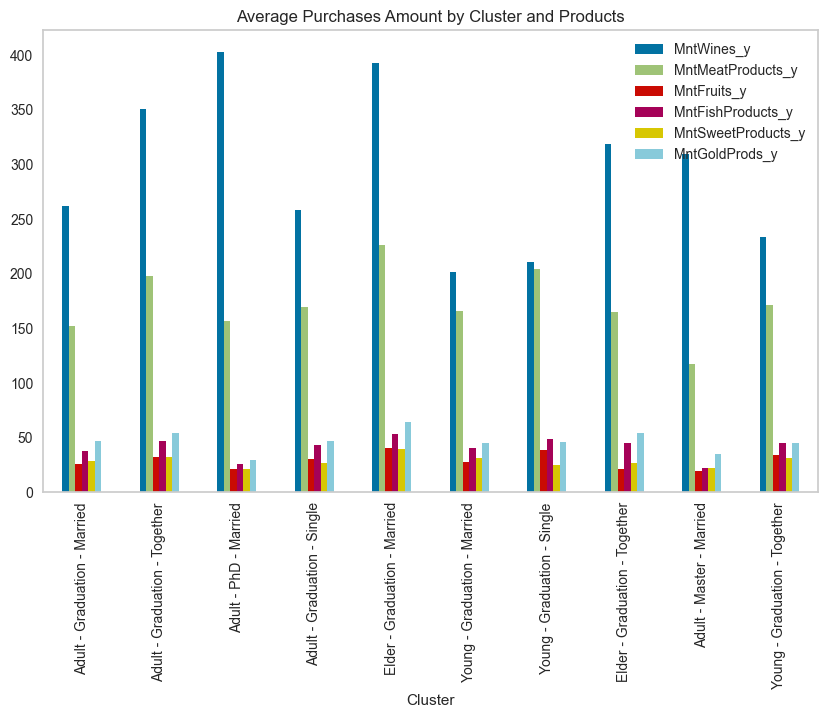

In [15]:
create_plot(
    cluster_df.head(10),
    ['MntWines_y', 'MntMeatProducts_y', 'MntFruits_y', 'MntFishProducts_y', 'MntSweetProducts_y', 'MntGoldProds_y'],
    'Cluster',
    title='Average Purchases Amount by Cluster and Products',
    sort='MntAllProducts_x',
)

***Q4. Conduct an impact analysis and which recommendation should you prioritize?***

There is a cost and benefit in any campaign that we do. In this case, there is a specific cost that will be incurred and also a specific revenue that will be generated after we contact each customer. If we are running my previous recommendation on focusing on the business' most important cluster, that means we are going to contact only users who are in the "Adult - Graduation - Married" cluster though can be extended to the other two similar clusters of "Adult - Graduation - Together" and "Adult - PhD - Married".

The graph below shows the projected total net benefit of contacting each cluster using the last campaign acceptance rate. The net revenue from only contacting the "Adult - Graduation - Married" cluster is estimated to be around 170. Additionally, if we were to include those two similar clusters, our estimated net benefit will become even higher.

Since I recommend for a more personalized campaign for the cluster, there is a possibility that it can take the first position in the future given an increased acceptance rate. 

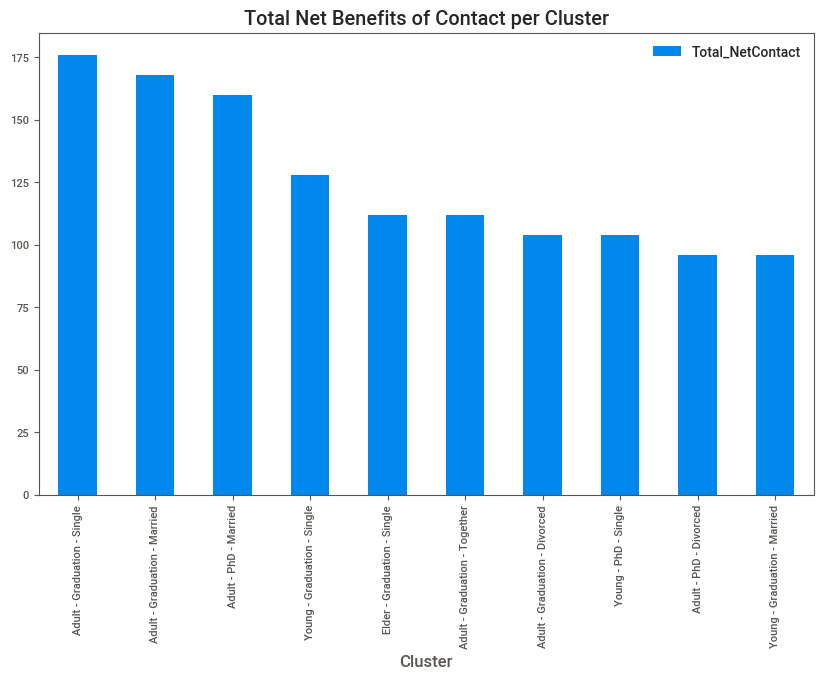

In [58]:
temp =\
(
    df
    .assign(
        Cluster = lambda x: x.AgeGroup.astype(str) + " - " + x.Education.astype(str) + " - " + x.Marital_Status.astype(str)
    )
    .groupby('Cluster')
    .nunique('ID')
    .sort_values('ID', ascending=False)
    [['ID']]
    .reset_index()
    .rename(columns={'ID':'UserCount'})
)

temp2 =\
(
    cluster_df
    .merge(temp, on='Cluster')
    .assign(
        Total_CostContact = lambda x: x.Z_CostContact_x,
        Total_RevContact = lambda x: x.Z_Revenue_x,
        Total_NetContact = lambda x: (x.Total_RevContact - x.Total_CostContact) * x.Response_y,
        Avg_NetContact = lambda x: x.Total_NetContact / x.UserCount
    )
    [['Cluster', 'Total_CostContact', 'Total_RevContact', 'Total_NetContact', 'Avg_NetContact']]
    
)


create_plot(
    temp2.sort_values('Total_NetContact', ascending=False).head(10),
    ['Total_NetContact'],
    'Cluster',
    title = "Total Net Benefits of Contact per Cluster"
)


In [ ]:
# test